In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importar datos
dfA = pd.read_excel('../01 - Datos bruto/01.21-12.22.xlsx')
dfB = pd.read_excel('../01 - Datos bruto/12.22-12.23.xlsx')
dfC = pd.read_excel('../01 - Datos bruto/12.23-07.24.xlsx')

# 1: Limpieza y preparación del Dataset General

In [3]:
#Concatenar
df = pd.concat([dfA, dfB, dfC])

In [4]:
#Checkear duplicados
df.duplicated().sum()

2837

In [5]:
#Eliminar duplicados
df = df.drop_duplicates()

In [6]:
#Renombrar columnas
columnas = ['nodos','fecha_arch', 'hora_arch', 'scanner', 'codigo', 'unidad_manipulac', 'entrega', 'posicion', 'doc_ventas', 'posicion2', 'material', 'denominacion', 'fecha_hist', 'hora_hist']
df = df.set_axis(columnas, axis = 1)

In [7]:
#Eliminar espacios antes y despues de strings
columns_to_strip = ['material', 'denominacion']
for col in columns_to_strip:
    df[col] = df[col].astype(str).str.strip()

In [8]:
#Combinar fechas
df = df.reset_index(drop=True)
df['fecha_arch'] = pd.to_datetime(df['fecha_arch'].str.strip(), format='%d.%m.%Y', errors='coerce')
df['fecha_hist'] = pd.to_datetime(df['fecha_hist'].str.strip(), format='%d.%m.%Y', errors='coerce')
df['fecha'] = df['fecha_arch'].combine_first(df['fecha_hist'])

In [9]:
#Combianr horas
df = df.reset_index(drop=True)
df['hora_arch'] = df['hora_arch'].astype(str)
df['hora_hist'] = df['hora_hist'].astype(str)
df['hora_arch'] = pd.to_timedelta(df['hora_arch'].str.strip(), errors='coerce')
df['hora_hist'] = pd.to_timedelta(df['hora_hist'].str.strip(), errors='coerce')
df['hora'] = df['hora_arch'].combine_first(df['hora_hist'])

In [10]:
#Eliminar fechas y horas anterior
df = df.drop(['fecha_arch', 'hora_arch', 'fecha_hist', 'hora_hist'], axis = 1)

In [11]:
df['hora'] >=  pd.to_timedelta('01:00:00')

0          True
1          True
2          True
3          True
4          True
           ... 
1481130    True
1481131    True
1481132    True
1481133    True
1481134    True
Name: hora, Length: 1481135, dtype: bool

In [12]:
def calcular_turno(row):
    if row['hora'] >= pd.to_timedelta('01:00:00') and row['hora'] <= pd.to_timedelta('15:15:00'):
        return 1
    else:
        return 2
    
df['turno'] = df.apply(calcular_turno, axis=1)

# 2: Linea de volúmenes SAPRFMADR16 y SAPRFMADR15. 

TRAS LA SEPARACIÓN DE LINEAS EN AGOSTO 2023 SE DEBERÍA SEPARAR PARA CALCULAR EL TAKT POR INDEPENDIENTE EN CADA LINEA. DE MOMENTO NO SE HA HECHO

## 2.1 preparación de los datos AÑADIR EDA!!!!

In [13]:
df_vols = df[(df['scanner'] == 'SAPRFMADR16') | (df['scanner'] == 'SAPRFMADR15')]

In [14]:
# Calculamos diferencia de tiempos entre piezas
df_vols['delta'] = df_vols['hora'].diff().dt.total_seconds()

# Comprobamos que no hay valores repetidos (Solo un escaneo rápido con 0 secs de diferencia se produjo)
df_vols[
    (df_vols['delta'] == 0)
]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26792\2433916700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vols['delta'] = df_vols['hora'].diff().dt.total_seconds()


,nodos,scanner,codigo,unidad_manipulac,entrega,posicion,doc_ventas,posicion2,material,denominacion,fecha,hora,turno,delta
11468,MADR,SAPRFMADR15,ZRF_M7,2314936854,89204918,10,9722335,20,P5SP_2111306,Taq 2050x600 1/1/1/1/D f.lami cerr digil,2021-01-15,0 days 11:55:24,1,0.0
32786,MADR,SAPRFMADR15,ZRF_M7,2314958386,89218807,10,9717639,400,PLOCKER_UV,UNIVERSAL LOCKER,2021-02-01,0 days 11:46:21,1,0.0
45853,MADR,SAPRFMADR15,ZRF_M1,2314972183,89244465,20,9704881,40,P785_PEDESTAL_001,BLQ IMPL 785/786,2021-02-12,0 days 08:27:12,1,0.0
46915,MADR,SAPRFMADR15,ZRF_M7,2314973252,89238209,20,9728981,500,P5035_CRED_PB,CRED VA2 PTA BAT IZQ/DER,2021-02-12,0 days 14:04:01,1,0.0
73786,MADR,SAPRFMADR16,ZRF_M7,2315000210,89273061,10,9740797,70,P785_PEDESTAL_001,BLQ IMPL 785/786,2021-03-12,0 days 11:41:00,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429600,MADR,SAPRFMADR15,ZRF_M7,2316361011,90886818,10,1408058,200,P785_PEDESTAL_001,BLQ IMPL 785/786,2024-06-03,0 days 12:50:18,1,0.0
1432550,MADR,SAPRFMADR16,ZRF_M7,2316364276,90879412,10,1411533,200,PSAVS1480797001,CARC ARM VA2 CRED 465X1200X470 P,2024-06-05,0 days 13:25:21,1,0.0
1441340,MADR,SAPRFMADR15,ZRF_M7,2316373106,90895841,320,1411707,9600,P546P_CAST_MET_1,BLQ IMPL C/R F MET 9/10UN P588,2024-06-17,0 days 10:59:43,1,0.0
1457407,MADR,SAPRFMADR15,ZRF_M7,2316389139,90907932,10,1411229,1400,P546P_CAST_MET_1,BLQ IMPL C/R F MET 9/10UN P588,2024-07-01,0 days 11:31:34,1,0.0


In [15]:
# Agregamos estado que represente si la pieza se ha producido tras un cambio de producto.
df_vols['cambio'] = (df_vols['material'] != df_vols['material'].shift()).astype(int)

# Añadimos un estado que represente pausas de > 10 mins
df_vols['pausa'] = ((df_vols['delta'] > 600) | (df_vols['delta'] < 0)).astype(int)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_26792\201405395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vols['cambio'] = (df_vols['material'] != df_vols['material'].shift()).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26792\201405395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vols['pausa'] = ((df_vols['delta'] > 600) | (df_vols['delta'] < 0)).astype(int)


In [16]:
# Estudiamos Takt Times de los vols filtrando los que se han hecho tras una pausa y tras cambio de producto.
# Ojo, en fabricados no se incluyen los que estén tras pausa y los que estén tras cambio prod.
df_vols_takt_filtr = df_vols[(df_vols['cambio'] == 0) & (df_vols['pausa'] == 0) & (df_vols['turno'] == 1)]

df_vols_takt_filtr_agrup = df_vols_takt_filtr.groupby(
    ['denominacion']
).agg({'delta' : ['mean', 'std', 'count']}).reset_index()

df_vols_takt_filtr_agrup.columns = ['denominacion', 'media_takt', 'dev_std', 'fabricados']

In [17]:
df_vols_takt_filtr_agrup = df_vols_takt_filtr_agrup.sort_values(by = 'fabricados', ascending= False)

<Axes: xlabel='denominacion', ylabel='fabricados'>

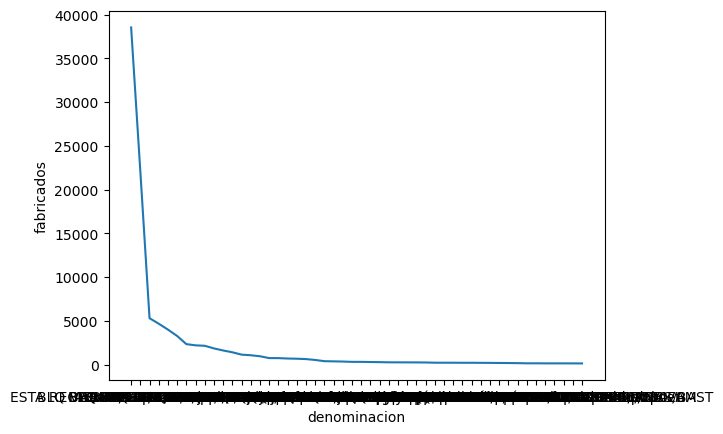

In [18]:
sns.lineplot(data = df_vols_takt_filtr_agrup.head(50), x= 'denominacion', y= 'fabricados')

In [19]:
df_vols_takt_filtr_agrup.head(59)

,denominacion,media_takt,dev_std,fabricados
205,BLQ IMPL 785/786,84.325797,66.382879,38527
64,ARM US3 PTA PERS,91.192752,58.221678,22075
219,BLQ VA 332/432 C/R 9/10/13 UN,84.943343,61.661339,5295
60,ARM US3 PTA BAT MET,102.445445,57.523491,4665
282,ESTA RECI 850X1000X450 SERI C/SUJ BOLSA,86.725952,49.005807,3992
58,ARM US3 PTA BAT LAM,105.737745,60.339736,3264
209,BLQ IMPL C/R F MET 9/10UN P588,90.617925,70.640602,2332
77,ARM VA2 CLIP PTA BAT MET P470,114.611212,61.730440,2194
76,ARM VA2 CLIP PTA BAT LAM P470,114.272642,63.349710,2142
632,USNG ARMARIO PERS,88.475054,63.462713,1844


<Axes: xlabel='media_takt', ylabel='Count'>

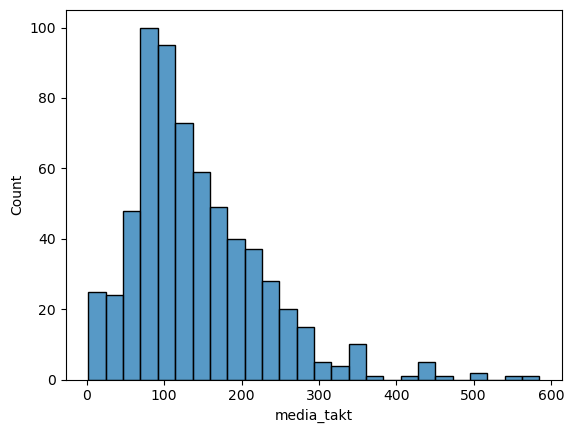

In [20]:
df_vols_takt_filtr_agrup = df_vols_takt_filtr_agrup[['denominacion', 'media_takt']]
sns.histplot(data = df_vols_takt_filtr_agrup, x= 'media_takt')

In [21]:
df_vols_volumen_dia = df_vols.groupby(['fecha', 'denominacion']).count().reset_index()[['fecha','denominacion','nodos']]
df_vols_volumen_dia['cantidad_fabricada'] = df_vols_volumen_dia['nodos'] 
df_vols_volumen_dia = df_vols_volumen_dia.drop('nodos', axis = 1)
df_vols_volumen_dia = df_vols_volumen_dia.merge(df_vols_takt_filtr_agrup, on = 'denominacion')
df_vols_volumen_dia['tiempo_trabajo'] = df_vols_volumen_dia['cantidad_fabricada'] * df_vols_volumen_dia['media_takt']

In [22]:
df_vols_volumen_dia

,fecha,denominacion,cantidad_fabricada,media_takt,tiempo_trabajo
0,2021-01-04,ARM US3 PTA BAT LAM,6,105.737745,634.426471
1,2021-01-19,ARM US3 PTA BAT LAM,1,105.737745,105.737745
2,2021-01-20,ARM US3 PTA BAT LAM,8,105.737745,845.901961
3,2021-01-21,ARM US3 PTA BAT LAM,3,105.737745,317.213235
4,2021-01-26,ARM US3 PTA BAT LAM,2,105.737745,211.475490
...,...,...,...,...,...
13924,2024-07-05,JARD REM VA2 370X1000X470,10,97.850000,978.500000
13925,2024-07-12,JARD REM VA2 370X1000X470,6,97.850000,587.100000
13926,2024-07-02,TAQ UV 1C 3G 07X04 ME-XX 2050X 400,2,46.000000,92.000000
13927,2024-07-11,CARC ESTA RECI 850X1000x450 P,2,2.000000,4.000000


In [23]:
df_vols_trabajo_diario = df_vols_volumen_dia.groupby(by='fecha').sum().reset_index()[['fecha', 'cantidad_fabricada', 'tiempo_trabajo']]
df_vols_trabajo_diario['tiempo_trabajo_horas'] = df_vols_trabajo_diario['tiempo_trabajo'] / 3600
df_vols_trabajo_diario

,fecha,cantidad_fabricada,tiempo_trabajo,tiempo_trabajo_horas
0,2021-01-04,258,28152.605747,7.820168
1,2021-01-05,362,31686.019867,8.801672
2,2021-01-07,307,32121.860049,8.922739
3,2021-01-08,201,18957.253448,5.265904
4,2021-01-11,75,7336.253791,2.037848
...,...,...,...,...
843,2024-07-12,193,21371.053340,5.936404
844,2024-07-15,172,16337.444706,4.538179
845,2024-07-16,205,21293.667241,5.914908
846,2024-07-17,107,13192.704825,3.664640


In [24]:
#Estudiar por semanas Y rellenar faltantes
df_vols_trabajo_diario['semana'] = df_vols_trabajo_diario['fecha'].dt.strftime('%Y-%U')
df_vols_trabajo_semanal = df_vols_trabajo_diario.drop('fecha', axis = 1).groupby(by = 'semana').sum().reset_index()

def semana_a_fecha(semana_str):
    year, week = map(int, semana_str.split('-'))
    # Crear una fecha base el primer día del año
    first_day_of_year = pd.Timestamp(year=year, month=1, day=1)
    # Calcular la fecha del primer día de la semana específica
    return first_day_of_year + pd.to_timedelta(week * 7 - first_day_of_year.dayofweek, unit='D')


df_vols_trabajo_semanal['semana_primer_dia'] = df_vols_trabajo_semanal['semana'].apply(semana_a_fecha)

In [25]:
#Rellenar semanas faltantes
semana_min = df_vols_trabajo_semanal['semana_primer_dia'].min()
semana_max = df_vols_trabajo_semanal['semana_primer_dia'].max()
todas_las_semanas = pd.date_range(semana_min, semana_max, freq='W-MON')
todas_las_semanas
df_todas_las_semanas = pd.DataFrame({'semana_primer_dia': todas_las_semanas})
df_completo = pd.merge(df_todas_las_semanas, df_vols_trabajo_semanal, on='semana_primer_dia', how='left')
df_completo['cantidad_fabricada'].fillna(0, inplace=True)
df_completo['tiempo_trabajo'].fillna(0, inplace=True)
df_completo['tiempo_trabajo_horas'].fillna(0, inplace=True)
df_completo['semana'] = df_completo['semana_primer_dia'].dt.isocalendar().week.astype(str) + "-" + df_completo['semana_primer_dia'].dt.year.astype(str)
df_completo.to_excel('trabajo_semanal.xlsx')
df_vols_trabajo_semanal = df_completo

## 2.2 Ploteo de Serie Temporal 

<Axes: xlabel='fecha', ylabel='tiempo_trabajo_horas'>

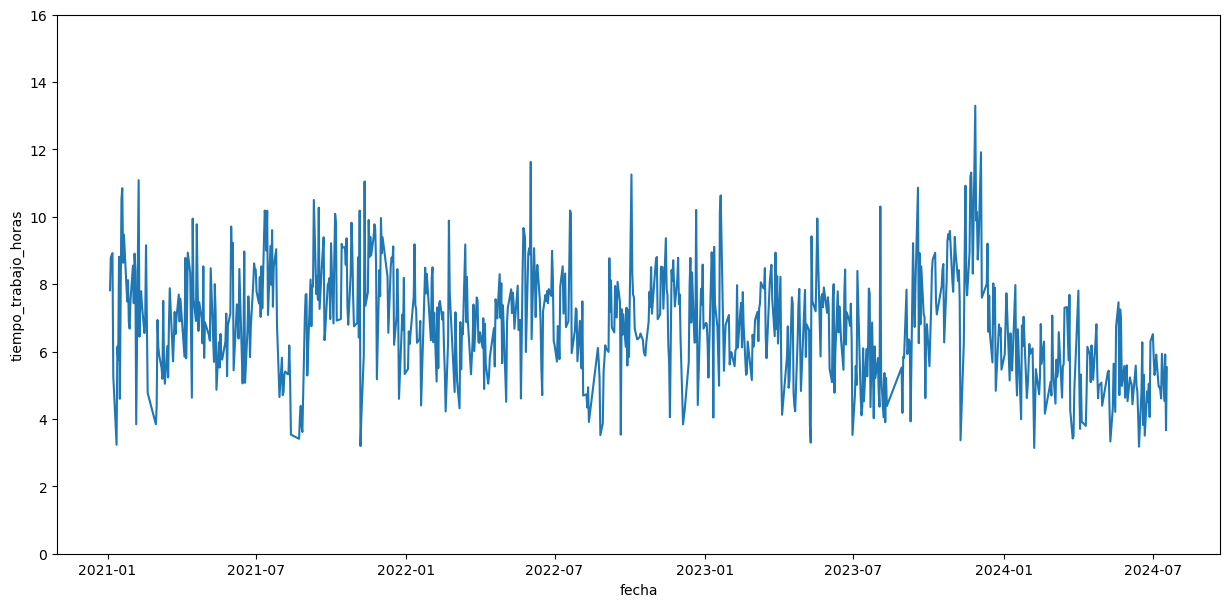

In [26]:
#Trabajo diario
dims = (15, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0, 16)
sns.lineplot(data = df_vols_trabajo_diario[df_vols_trabajo_diario['tiempo_trabajo_horas'] > 3], x= 'fecha', y= 'tiempo_trabajo_horas')

<Axes: xlabel='semana_primer_dia', ylabel='tiempo_trabajo_horas'>

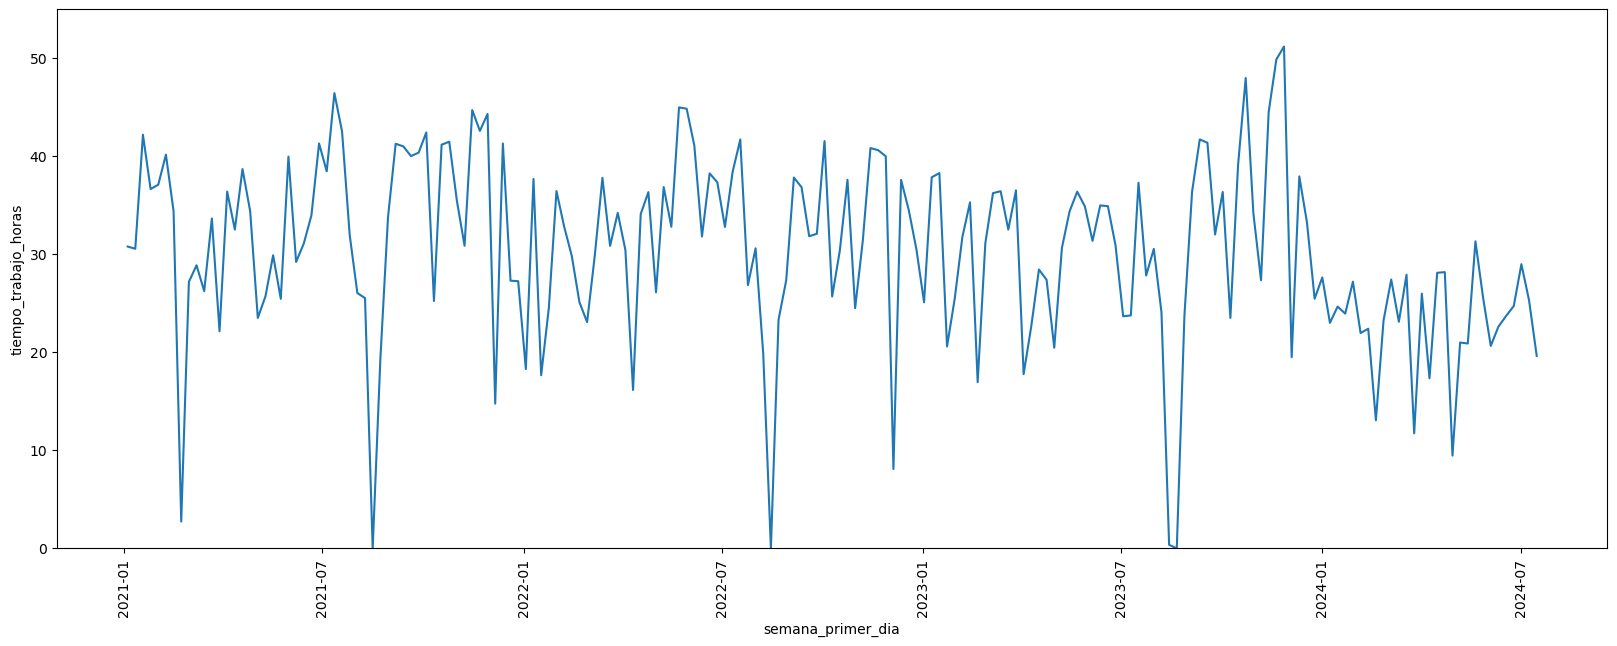

In [27]:
#Trabajo Semanal en Horas 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0, 55)
plt.xticks(rotation=90)
sns.lineplot(data = df_vols_trabajo_semanal, x= 'semana_primer_dia', y= 'tiempo_trabajo_horas')

<Axes: xlabel='semana_primer_dia', ylabel='cantidad_fabricada'>

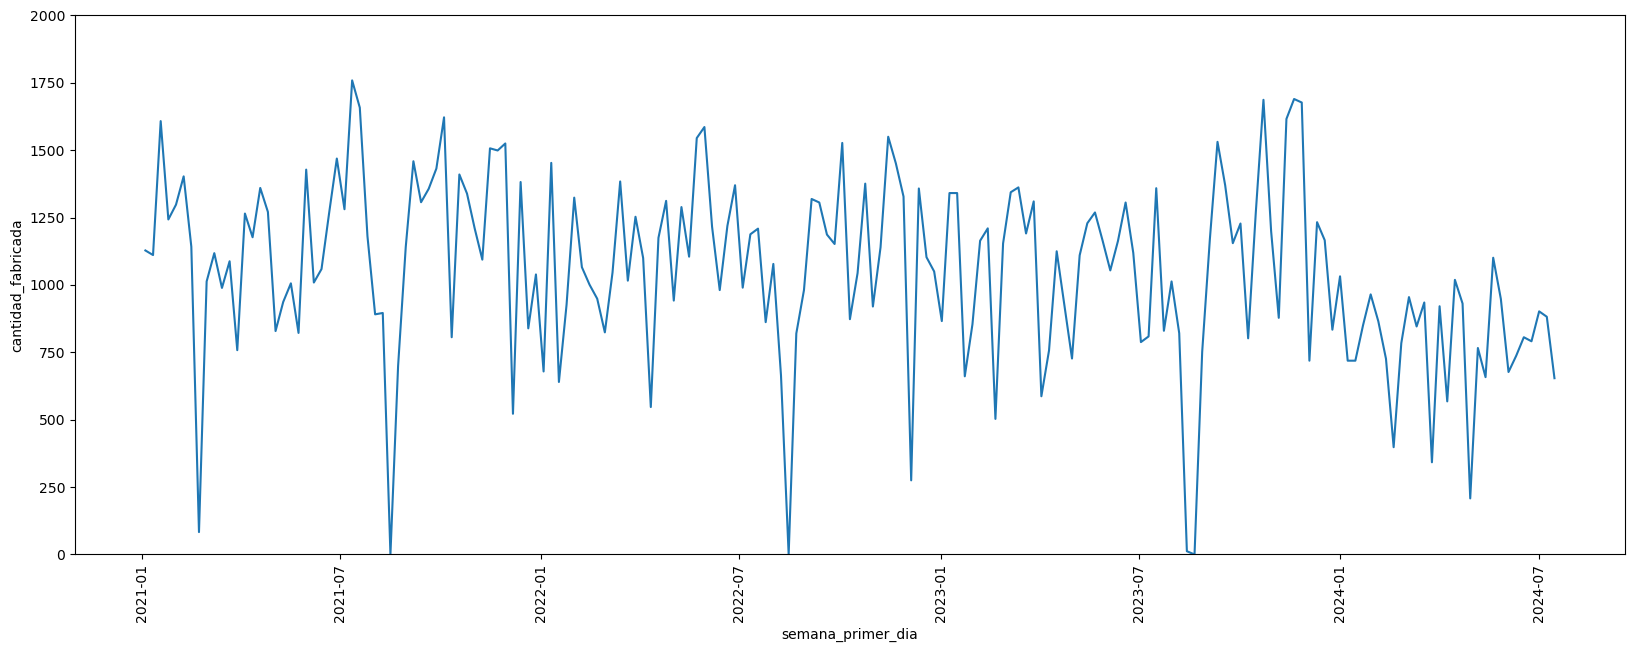

In [28]:
#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0, 2000)
plt.xticks(rotation=90)
sns.lineplot(data = df_vols_trabajo_semanal, x= 'semana_primer_dia', y= 'cantidad_fabricada')

## 2.3: PROPHET

In [29]:
#Preparar dataset
df_prophet = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_prophet = df_prophet.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo'], axis=1)

#Dividir train test --> SIMPLE TIME SPLIT
#https://forecastegy.com/posts/time-series-cross-validation-python/

#Predeciremos 4 meses.
fecha_limite = '2024-04-01'
df_prophet_train = df_prophet[df_prophet['ds'] < pd.to_datetime(fecha_limite)]
df_prophet_test = df_prophet[df_prophet['ds'] >= pd.to_datetime(fecha_limite)]
print('Cantidad datos entrenamiento: ' + str(len(df_prophet_train)))
print('Cantidad datos test: ' + str(len(df_prophet_test)))

Cantidad datos entrenamiento: 169
Cantidad datos test: 16


19:14:25 - cmdstanpy - INFO - Chain [1] start processing
19:14:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


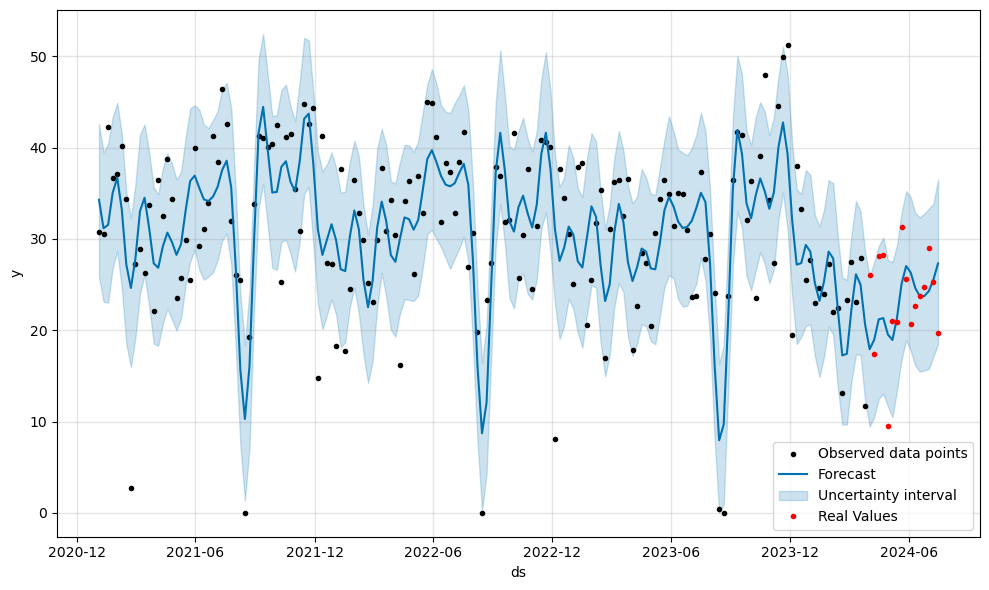

C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, ca

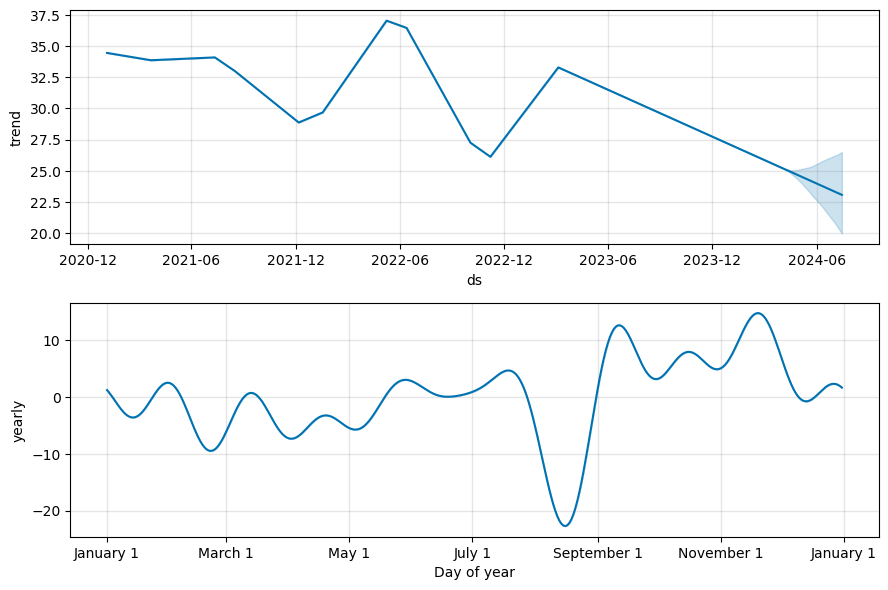

In [30]:
# Crear y entrenar el modelo Prophet
from prophet import Prophet

#model =  Prophet()
#model =  Prophet(interval_width=0.8)

# changepoint_prior_scale Indica la flexibiliad (adaabilidad) del modelo, permite ajustar la tendencia. 
# Por defecto 0.05. Mejor valor 3 por prueba y error.
# Interval Width es el intervalo de confianza.
model = Prophet(changepoint_prior_scale=3, interval_width=0.8)  

model.fit(df_prophet_train)

# Realizar una predicción para el futuro
future = model.make_future_dataframe(periods=len(df_prophet_test), freq='W-MON')
forecast = model.predict(future)

# Graficar los resultados
fig1 = model.plot(forecast)
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], 'r.', label='Real Values')
plt.legend()
plt.show()

# Opcional: graficar los componentes de la predicción
fig2 = model.plot_components(forecast)
plt.show()

Error Prophet: 6.813361063428811


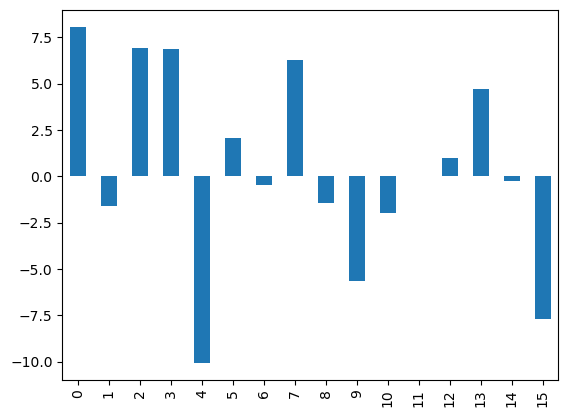

In [31]:
#Preparar dataset de comparación
df_forecast_comparison = forecast[['ds','yhat']].tail(len(df_prophet_test))
df_forecast_comparison = df_forecast_comparison.merge(df_prophet_test, on= 'ds')
df_forecast_comparison['error'] =  df_forecast_comparison['y'] - df_forecast_comparison['yhat']
#Parece centrado en 0. Buena señal
df_forecast_comparison['error'].plot(kind = 'bar')
print('Error Prophet: ' + str(df_forecast_comparison['error'].sum()))

In [32]:
df_forecast_comparison

,ds,yhat,y,error
0,2024-04-01,17.922656,26.000594,8.077938
1,2024-04-08,18.955027,17.359362,-1.595665
2,2024-04-15,21.195347,28.127679,6.932332
3,2024-04-22,21.326034,28.198280,6.872246
4,2024-04-29,19.532338,9.473206,-10.059131
5,2024-05-06,18.929907,21.016406,2.086499
6,2024-05-13,21.355215,20.911536,-0.443679
7,2024-05-20,25.078176,31.339899,6.261723
8,2024-05-27,27.033999,25.574404,-1.459595
9,2024-06-03,26.322619,20.670170,-5.652449


In [33]:
#Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE PROPHET: ' + str(mean_squared_error(df_forecast_comparison['y'], df_forecast_comparison['yhat']) ** (1/2)))
print ('MAE PROPHET: ' + str(mean_absolute_error(df_forecast_comparison['y'], df_forecast_comparison['yhat'])))
print ('MAPE PROPHET: ' + str(mean_absolute_percentage_error(df_forecast_comparison['y'], df_forecast_comparison['yhat'])))

RMSE PROPHET: 5.173427127488182
MAE PROPHET: 4.067123860048564
MAPE PROPHET: 0.20605735546669843


### 2.3.1: CROSS VALIDATION - EXPANDING WINDOW VALIDATION

In [34]:
#Expanding Window
RMSE_phrophet_window = []
MAE_phrophet_window =[]
MAPE_prophet_window = []

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=11, test_size = 16)

#Fijamos 16 como test size para siempre predecir 4 meses
# tscv = TimeSeriesSplit(n_splits=20)

import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)  # O logging.ERROR


#Descomentar para entender como funcionan los indices.
# for train_index, test_index in tscv.split(df_prophet['y']):
#     print("Train indices:", train_index, "Test indices:", test_index)

for train_index, test_index in tscv.split(df_prophet['y']):
    df_prophet_train_window = df_prophet.iloc[train_index]
    df_prophet_test_window = df_prophet.iloc[test_index]

    model = Prophet(changepoint_prior_scale=3, interval_width=0.8)  

    model.fit(df_prophet_train_window)
    
    # Realizar una predicción para el futuro
    future = model.make_future_dataframe(periods=len(df_prophet_test_window), freq='W-MON')
    forecast = model.predict(future)

    df_forecast_comparison = forecast[['ds','yhat']].tail(len(df_prophet_test_window))
    df_forecast_comparison = df_forecast_comparison.merge(df_prophet_test_window, on= 'ds')
    df_forecast_comparison['error'] =  df_forecast_comparison['y'] - df_forecast_comparison['yhat']

    RMSE_phrophet_window.append(mean_squared_error(df_forecast_comparison['y'], df_forecast_comparison['yhat']) ** (1/2))
    MAE_phrophet_window.append(mean_absolute_error(df_forecast_comparison['y'], df_forecast_comparison['yhat']))
    MAPE_prophet_window.append(mean_absolute_percentage_error(df_forecast_comparison['y'], df_forecast_comparison['yhat']))


In [35]:
data = {
    'RMSE': RMSE_phrophet_window,
    'MAE': MAE_phrophet_window,
    #'MAPE': MAPE_prophet_window
}
prophet_window_results = pd.DataFrame(data)

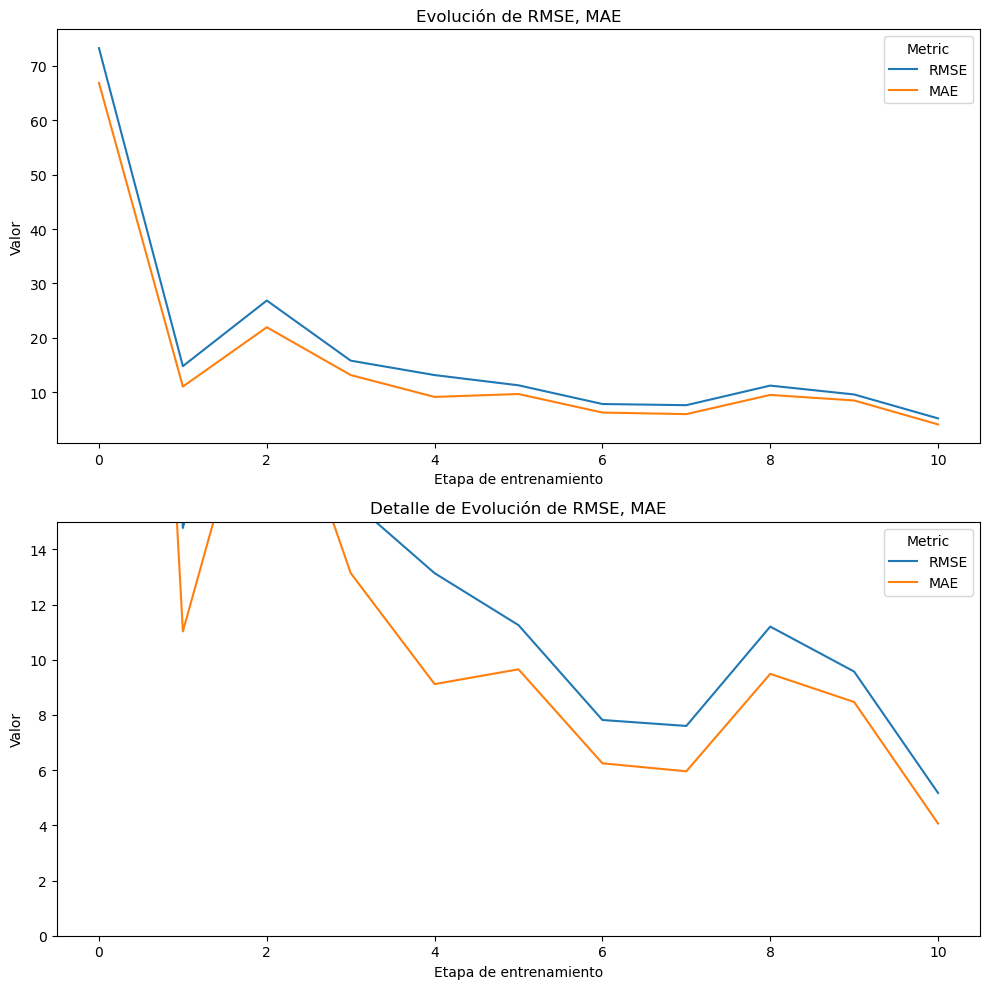

In [36]:
df_long = prophet_window_results.melt(var_name='Metric', value_name='Value')
df_long['Index'] = df_long.groupby('Metric').cumcount()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # 2 filas, 1 columna

sns.lineplot(data=df_long, x='Index', y='Value', hue='Metric', ax=ax1)
# plt.ylim((0,30))
ax1.set_title('Evolución de RMSE, MAE')
ax1.set_xlabel('Etapa de entrenamiento')
ax1.set_ylabel('Valor')

sns.lineplot(data=df_long, x='Index', y='Value', hue='Metric', ax=ax2)
ax2.set_ylim((0,15))
ax2.set_title('Detalle de Evolución de RMSE, MAE')
ax2.set_xlabel('Etapa de entrenamiento')
ax2.set_ylabel('Valor')

plt.tight_layout() 
plt.show()

### 2.3.2: Previsión de 4 meses. AÑADIR FESTIVOS!!!

C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


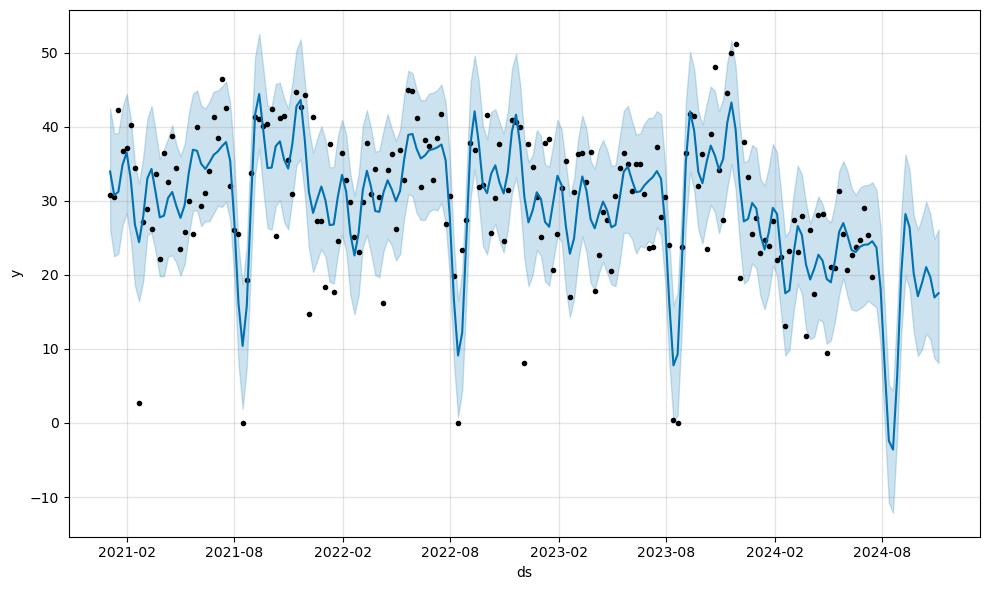

C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Usuario\anaconda3\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, ca

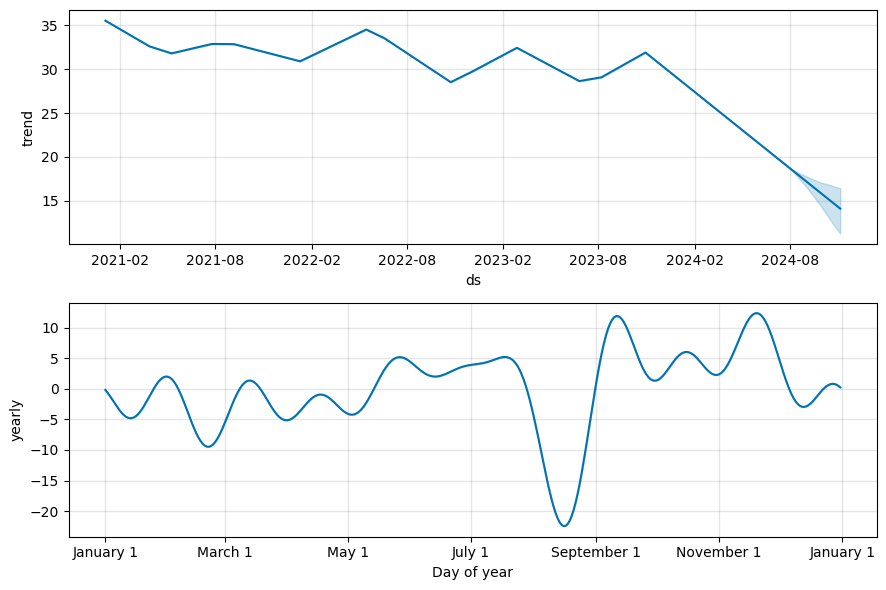

In [37]:
model = Prophet(changepoint_prior_scale=3, interval_width=0.8)  

model.fit(df_prophet)

# Realizar una predicción para el futuro
future = model.make_future_dataframe(periods=16, freq='W-MON')
forecast = model.predict(future)

forecast_prophet = forecast[forecast['ds'] > pd.to_datetime('2024-07-21')][['ds', 'yhat']]

# Graficar los resultados
fig1 = model.plot(forecast)
plt.show()

# Opcional: graficar los componentes de la predicción
fig2 = model.plot_components(forecast)
plt.show()

## 2.4: SARIMAX (Arima pero con variables exógenas, probar nº semnana, semana santa y festivos): Ajuste FINO y GRÁFICAS!!!!

In [38]:
#Preparar dataset
df_sarima = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_sarima = df_sarima.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo'], axis=1)

#Predeciremos 4 meses.
fecha_limite = '2024-04-01'
df_sarima_train = df_sarima[df_sarima['ds'] < pd.to_datetime(fecha_limite)]
df_sarima_test = df_sarima[df_sarima['ds'] >= pd.to_datetime(fecha_limite)]

df_sarima.set_index('ds', inplace = True)
df_sarima_train.set_index('ds', inplace = True)
df_sarima_test.set_index('ds', inplace = True)

print('Cantidad datos entrenamiento: ' + str(len(df_sarima_train)))
print('Cantidad datos test: ' + str(len(df_sarima_test)))

Cantidad datos entrenamiento: 169
Cantidad datos test: 16


In [39]:
import warnings
warnings.filterwarnings("ignore")
from sktime.forecasting.sarimax import SARIMAX
from joblib import Parallel, delayed
from math import sqrt
import time

#PARALELIZADO!!!!!!!!!

#ITERATE = True
ITERATE = False

def adjust_model(order_input, seasonal_order_input):

    try:
        # Crear y ajustar el modelo SARIMAX
        forecaster = SARIMAX(order=order_input, trend="t", seasonal_order=seasonal_order_input)
        forecaster.fit(df_sarima_train['y'])

        # Realizar la predicción
        y_pred_sarima = forecaster.predict(fh=df_sarima_test.index)
        y_pred_sarima = pd.DataFrame(y_pred_sarima).reset_index()
        y_pred_sarima = y_pred_sarima.rename(columns={"index": "ds", "y": "yhat"})

        # Calcular el RMSE
        df_forecast_comparison = y_pred_sarima.merge(df_sarima_test, on='ds')
        df_forecast_comparison['error'] = df_forecast_comparison['y'] - df_forecast_comparison['yhat']

        rmse = mean_squared_error(df_forecast_comparison['y'], df_forecast_comparison['yhat']) ** 0.5

        print(order_input)
        print(seasonal_order_input)
        print(rmse)

    except Exception as e:
        print(f"Error with order: {order}, seasonal_order: {seasonal_order} - {e}")

    return order_input, seasonal_order_input, rmse

rp = 5
rd = 2
rq = 5

rP = 5
rD = 1
rQ = 5
rS  = 52


pdq = [(p, d, q) for p in range(0, rp) for d in range(0, rd) for q in range(0, rq)]
seasonal_pdq = [(P, D, Q, s) for P in range(0, rP) for D in range(0, rD) for Q in range(0, rQ) for s in [rS]]

if ITERATE:
    results = Parallel(n_jobs= -1)(delayed(adjust_model)(i, j) for i in pdq for j in seasonal_pdq)

In [40]:
if ITERATE:
    best_rmse = float('inf')
    best_pdq = None
    best_seasonal_pdq = None
    
    order_array = []
    seasonal_order_array= []
    rmse_array = []
    
    for result in results:
        order = result[0]
        seasonal_order = result[1]
        rmse = result[2]
        
        order_array.append(order)
        seasonal_order_array.append(seasonal_order)
        rmse_array.append(rmse)
    
        if rmse < best_rmse:
            best_pdq = order
            best_seasonal_pdq = seasonal_order
            best_rmse = rmse
    
    print(best_pdq)
    print(best_seasonal_pdq)
    print(best_rmse)
    
    results_df = pd.DataFrame({
        'pdq': order_array, 
        'sea_pdq': seasonal_order_array,
        'rmse': rmse_array
        })

    output_route = '../03 - Output/iterations/sarima_iterations' + '_' + str(rp) + str(rd) + str(rq) + '_' + str(rP) + str(rD) + str(rQ) + str(rS) + '.xlsx'
    
    results_df.to_excel(output_route)

else:
    best_pdq = (1, 0, 1)
    best_seasonal_pdq = (2, 0, 1, 52)
    best_rmse = 4.4967

In [41]:
#Predicción
from sktime.forecasting.sarimax import SARIMAX

#Ajustar HIPERPARÁMETROS!!!!
# forecaster = SARIMAX( order=(1, 0, 0), trend="t", seasonal_order=(1, 0, 0, 52))
forecaster = SARIMAX( order=best_pdq, trend="t", seasonal_order=best_seasonal_pdq)

forecaster.fit(df_sarima_train['y'])  
y_pred_sarima = forecaster.predict(fh=df_sarima_test.index)  

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
#Vovler a crear Índices
y_pred_sarima = pd.DataFrame(y_pred_sarima).reset_index()
y_pred_sarima = y_pred_sarima.rename(columns={"index": "ds", "y": "yhat"})

df_sarima_test = df_sarima_test.reset_index()

suma de errores: 4.1852931719241475


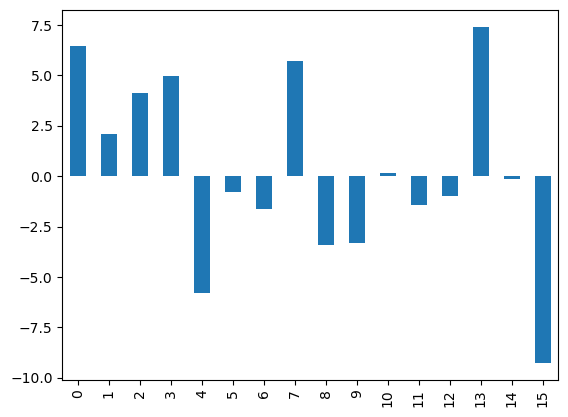

In [43]:
#Preparar dataset de comparación
df_forecast_comparison_sarima = y_pred_sarima.merge(df_sarima_test, on= 'ds')
df_forecast_comparison_sarima['error'] =  df_forecast_comparison_sarima['y'] - df_forecast_comparison_sarima['yhat']
# #Parece centrado en 0. Buena señal
df_forecast_comparison_sarima['error'].plot(kind = 'bar')
print('suma de errores: ' + str(df_forecast_comparison_sarima['error'].sum()))

In [44]:
#Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE SARIMA: ' + str(mean_squared_error(df_forecast_comparison_sarima['y'], df_forecast_comparison_sarima['yhat']) ** (1/2)))
print ('MAE SARIMA: ' + str(mean_absolute_error(df_forecast_comparison_sarima['y'], df_forecast_comparison_sarima['yhat'])))
print ('MAPE SARIMA: ' + str(mean_absolute_percentage_error(df_forecast_comparison_sarima['y'], df_forecast_comparison_sarima['yhat'])))

RMSE SARIMA: 4.496741646777015
MAE SARIMA: 3.607310363036139
MAPE SARIMA: 0.1709078386807083


<Axes: xlabel='ds', ylabel='y'>

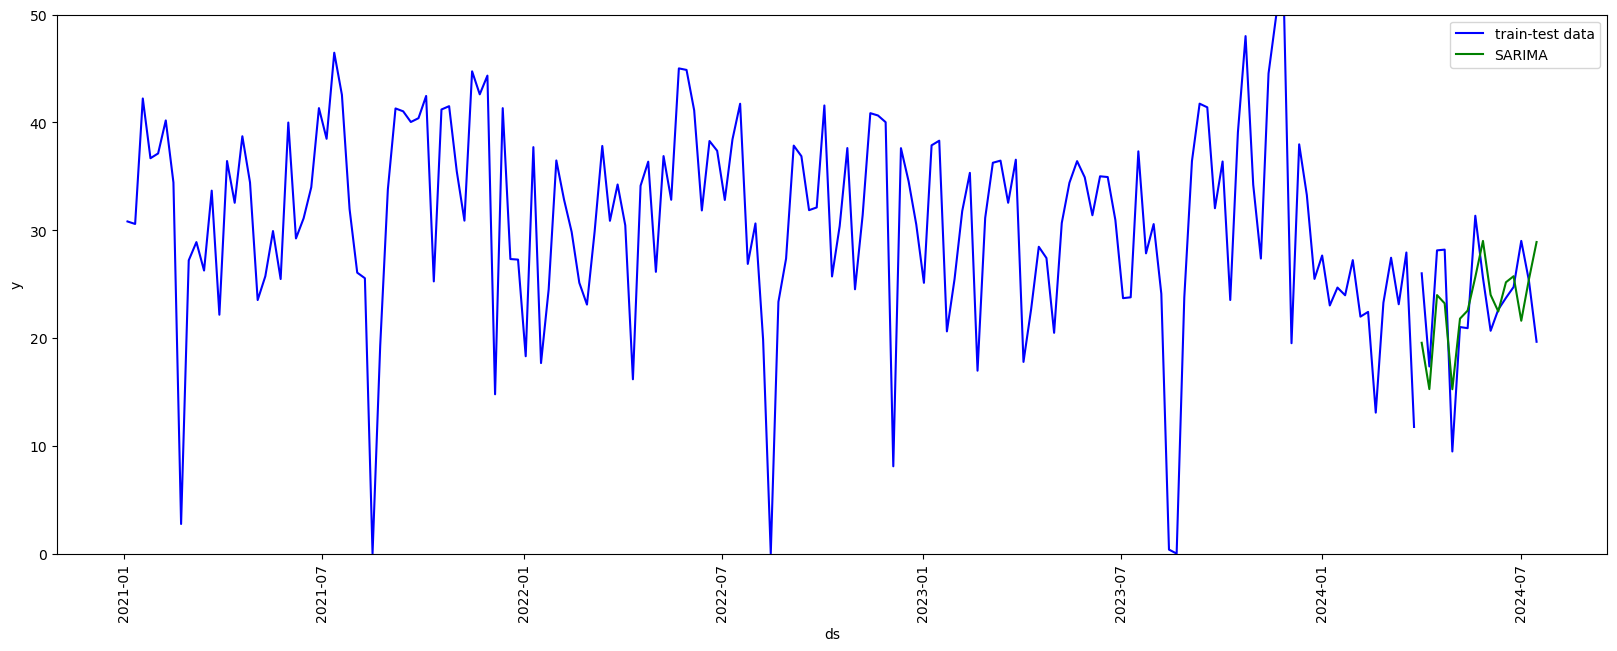

In [45]:
#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
plt.xticks(rotation=90)
sns.lineplot(data = df_sarima_train, x= df_sarima_train.index, y= 'y', color = 'blue', label = 'train-test data')
sns.lineplot(data = df_sarima_test, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_sarima, x= 'ds', y= 'yhat', color = 'green', label = 'SARIMA')

Predecir valores futuros

In [46]:
#Predicción
from sktime.forecasting.sarimax import SARIMAX

forecaster = SARIMAX( order=best_pdq, trend="t", seasonal_order=best_seasonal_pdq)

forecaster.fit(df_sarima['y'])  

# Última fecha de tu serie temporal
last_date = pd.to_datetime('2024-07-15')

# Generar los índices de las próximas 16 semanas
future_dates = pd.date_range(start=last_date, periods=17, freq='W-MON')[1:]


y_pred_sarima = forecaster.predict(fh=future_dates)  

#Vovler a crear Índices
y_pred_sarima = pd.DataFrame(y_pred_sarima).reset_index()
y_pred_sarima = y_pred_sarima.rename(columns={"index": "ds", "y": "yhat"})


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='ds', ylabel='y'>

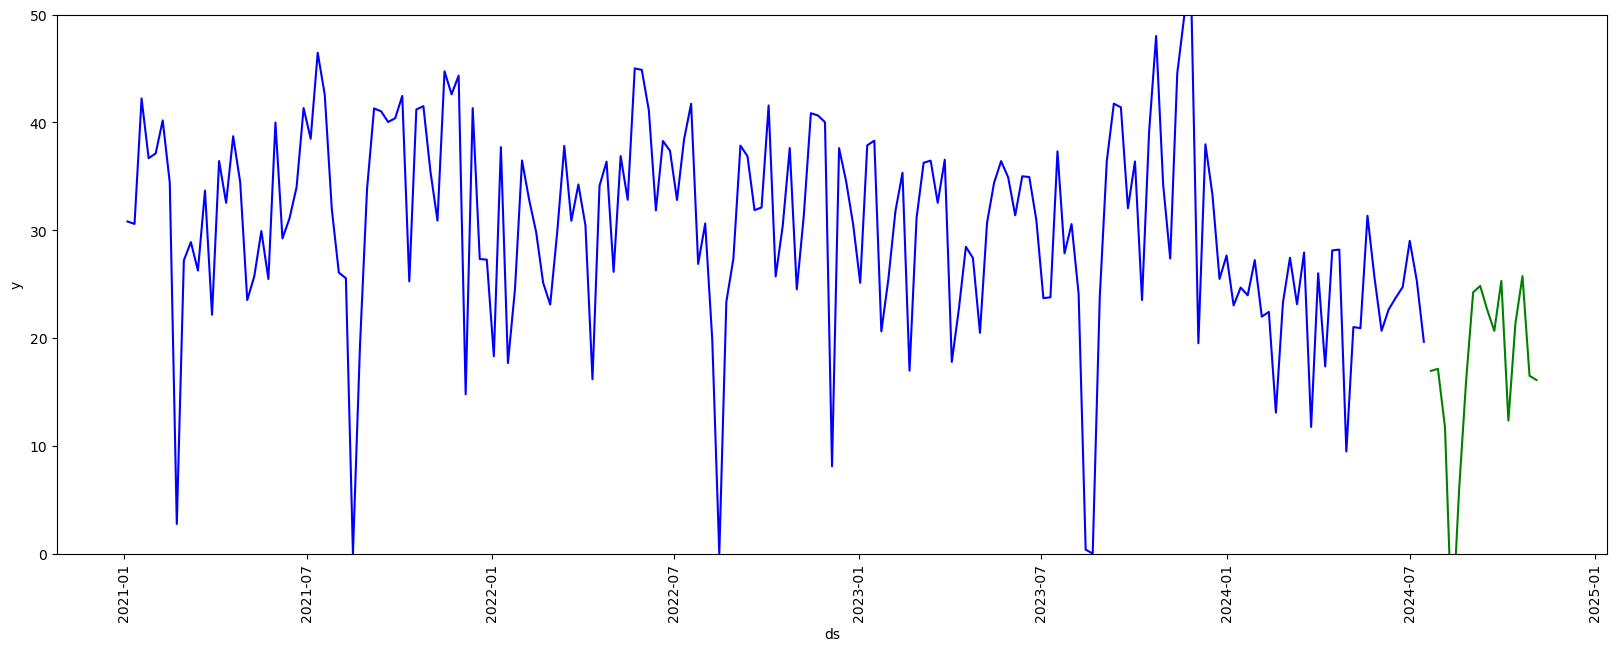

In [47]:
#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
plt.xticks(rotation=90)
sns.lineplot(data = df_sarima, x= df_sarima.index, y= 'y', color = 'blue')
sns.lineplot(data = y_pred_sarima, x= 'ds', y= 'yhat', color = 'green')

## 2.5: Exponential Smoothing - Holt Winters

In [48]:
#Preparar dataset
df_exp = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_exp = df_exp.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo'], axis=1)

#Dividir train test --> SIMPLE TIME SPLIT
#https://forecastegy.com/posts/time-series-cross-validation-python/

#Predeciremos 4 meses.
fecha_limite = '2024-04-01'
df_exp_train = df_exp[df_exp['ds'] < pd.to_datetime(fecha_limite)]
df_exp_test = df_exp[df_exp['ds'] >= pd.to_datetime(fecha_limite)]
print('Cantidad datos entrenamiento: ' + str(len(df_exp_train)))
print('Cantidad datos test: ' + str(len(df_exp_test)))

Cantidad datos entrenamiento: 169
Cantidad datos test: 16


In [49]:
#Búsqueda de hiperparámetros para mejorar RMSE NO FUNCIONA!!! SI SE USAN EN EL MODELO DE PREDICCION NO TIENE SENTIDO.!!!!

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

ITERATE = False

# Definir los valores para el grid search
param_grid = np.arange(0, 1.05, 0.05)  # Rango de 0 a 1 con pasos de 0.05

# Función para entrenar el modelo y calcular el RMSE
def evaluate_params(alpha, beta, gamma):
    model = ExponentialSmoothing(
        df_exp_train['y'], 
        trend='add', 
        seasonal='add', 
        seasonal_periods=52
    ).fit(
        smoothing_level=alpha,
        smoothing_slope=beta,
        smoothing_seasonal=gamma,
        optimized=False
    )

    # Predecir con el modelo ajustado
    y_pred_exp = model.forecast(16)

    # Calcular el RMSE
    rmse_exp = mean_squared_error(df_exp_test['y'], y_pred_exp) ** 0.5

    print(alpha, beta, gamma, rmse_exp)

    return (alpha, beta, gamma, rmse_exp)

if ITERATE:

    # Ejecutar la búsqueda en paralelo
    results = Parallel(n_jobs=-1)(delayed(evaluate_params)(alpha, beta, gamma)
                                  for alpha in param_grid
                                  for beta in param_grid
                                  for gamma in param_grid)

    # Identificar la mejor combinación de parámetros
    best_result = min(results, key=lambda x: x[3])
    best_alpha, best_beta, best_gamma, best_rmse = best_result

else:
    #calculado con salto 0.01, Trend, Seasonal = add, NO mul, 0.05 da igual resultado.
    best_alpha = 0.05
    best_beta = 0.3
    best_gamma = 0.2
    best_rmse = 4.37

# Imprimir los mejores parámetros y el RMSE correspondiente
print("Mejores parámetros:")
print("Alpha:", best_alpha)
print("Beta:", best_beta)
print("Gamma:", best_gamma)
print("Mejor RMSE:", best_rmse)


Mejores parámetros:
Alpha: 0.05
Beta: 0.3
Gamma: 0.2
Mejor RMSE: 4.37


RMSE: 5.001286480349138


<Axes: xlabel='ds', ylabel='y'>

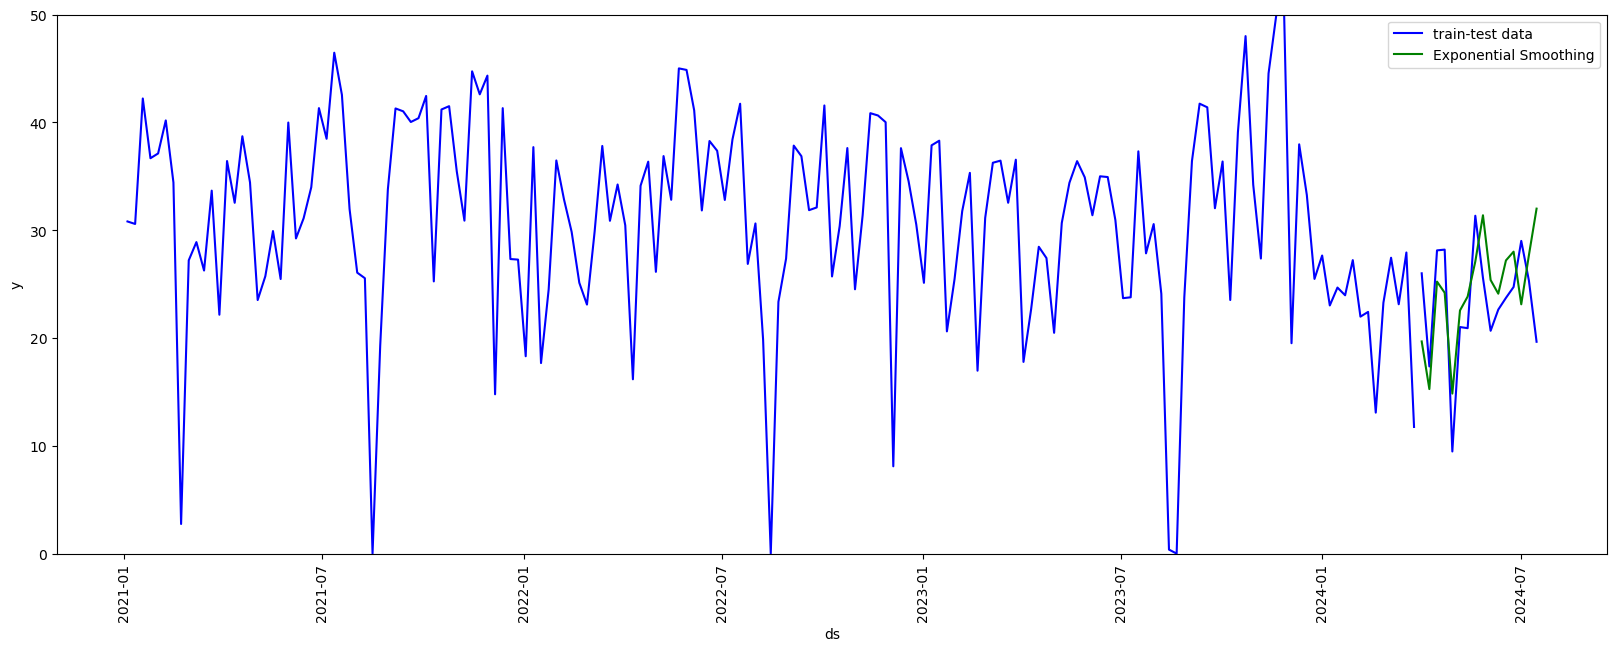

In [50]:
#Ajuste parámetros optimizados NO FUNCIONA!!! SI SE USAN EN EL MODELO DE PREDICCION NO TIENE SENTIDO.!!!!
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    df_exp_train['y'], 
    trend='add', #mul
    seasonal='add', #mul
    seasonal_periods=52
).fit(
    #Ajuste automático!!!!! No funciona ajuste iterativo ya que últimos valores cambian con nuevos datos.
    # smoothing_level= best_alpha,  # Alpha
    # smoothing_slope= best_beta,  # Beta
    # smoothing_seasonal= best_gamma,  # Gamma
    # optimized= False  # No optimizar automáticamente
)

y_pred_exp = model.forecast(16)

data = {
    'ds': df_exp_test['ds'],
    'yhat': y_pred_exp
}

y_pred_exp = pd.DataFrame(data)
rmse_exp = mean_squared_error(df_exp_test['y'], y_pred_exp['yhat']) ** (1/2)
print('RMSE: ' + str(rmse_exp))

#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
plt.xticks(rotation=90)
sns.lineplot(data = df_exp_train, x= 'ds', y= 'y', color = 'blue', label = 'train-test data')
sns.lineplot(data = df_exp_test, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'green', label = 'Exponential Smoothing')

suma de errores: -17.86097882608781


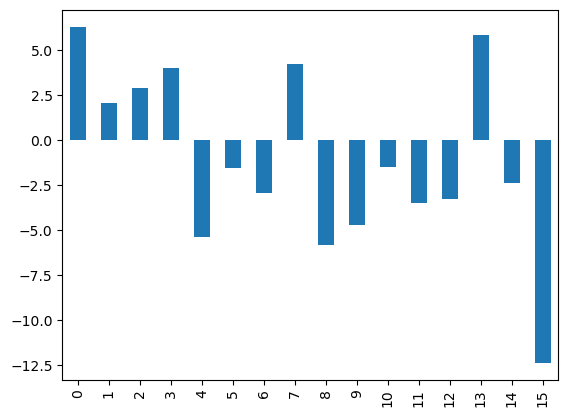

In [51]:
#Preparar dataset de comparación
df_forecast_comparison_exp = df_exp_test.merge(y_pred_exp, on= 'ds')
df_forecast_comparison_exp['error'] =  df_forecast_comparison_exp['y'] - df_forecast_comparison_exp['yhat']
#Parece centrado en 0. Buena señal
df_forecast_comparison_exp['error'].plot(kind = 'bar')
print('suma de errores: ' + str(df_forecast_comparison_exp['error'].sum()))

In [52]:
#Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE Exponential Smoothing: ' + str(mean_squared_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat']) ** (1/2)))
print ('MAE Exponential Smoothing: ' + str(mean_absolute_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat'])))
print ('MAPE Exponential Smoothing: ' + str(mean_absolute_percentage_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat'])))

RMSE Exponential Smoothing: 5.001286480349138
MAE Exponential Smoothing: 4.296520042818995
MAPE Exponential Smoothing: 0.2030226941680048


In [53]:
#Predicciones Futuras

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    df_exp['y'], 
    trend='add', #mul
    seasonal='add', #mul
    seasonal_periods=52
).fit(
    # smoothing_level=best_alpha,  # Alpha
    # smoothing_slope=best_beta,  # Beta
    # smoothing_seasonal=best_gamma,  # Gamma
    # optimized=False  # No optimizar automáticamente
 )

y_pred_exp = model.forecast(16)

data = {
    'ds': future_dates,
    'yhat': y_pred_exp
}

y_pred_exp = pd.DataFrame(data)


<Axes: xlabel='ds', ylabel='y'>

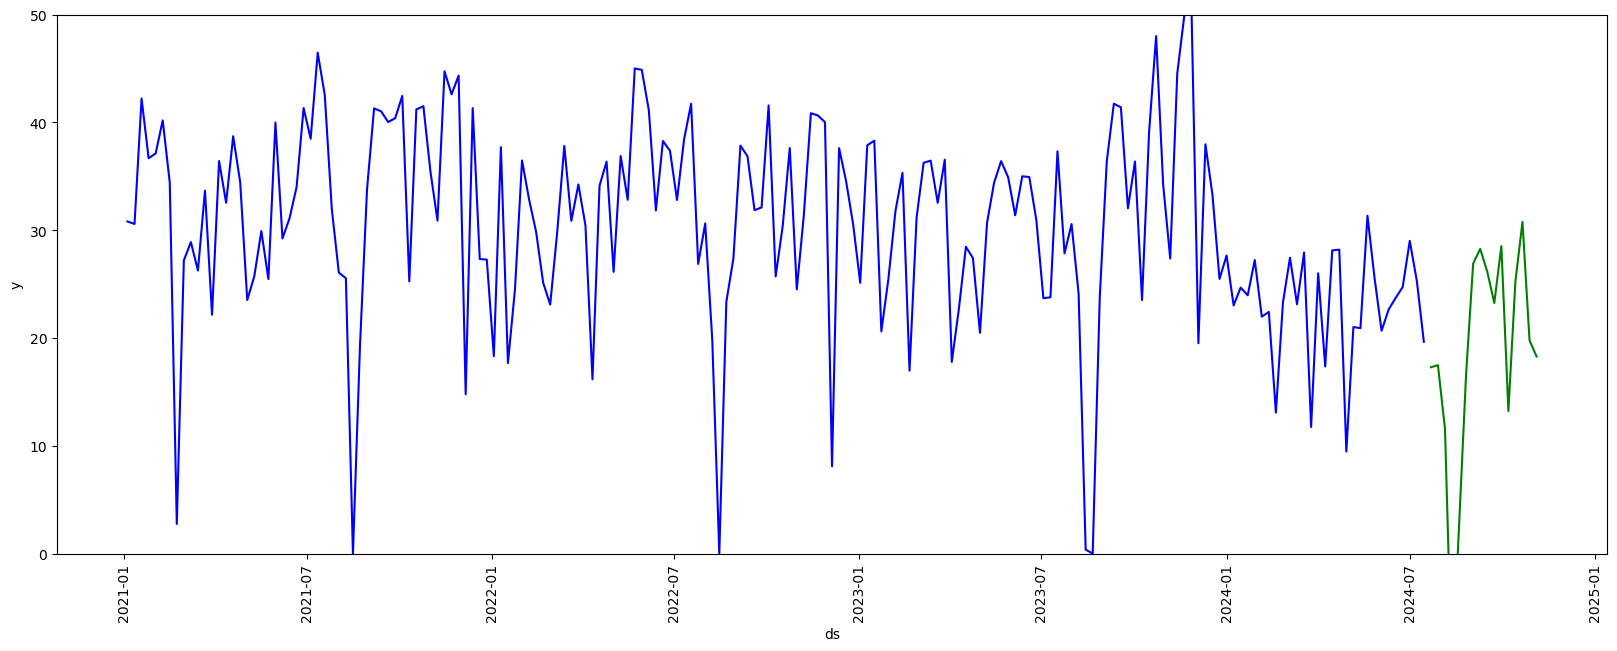

In [54]:
#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
plt.xticks(rotation=90)
sns.lineplot(data = df_exp, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'green')

## 2.6 XG Boost

In [55]:
df_xg = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_xg = df_xg.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo'], axis=1)
df_xg['week'] = df_xg['ds'].dt.isocalendar().week
df_xg['year'] = df_xg['ds'].dt.isocalendar().year
df_xg['month'] = df_xg['ds'].dt.month

def is_holiday(y):
    
    # Si y no es None, aplicar el criterio original
    if y < 10:
        return 1
    else:
        return 0

def is_holiday_future(ds):
    week = ds.isocalendar().week
    month = ds.month
    
    # Verificar si la semana está en las semanas 32 o 33 de agosto
    if (week == 32 or week == 33) and month == 8:
        return 1
    else:
        return 0

df_xg['holiday'] = df_xg.apply(lambda row: is_holiday(row['y']), axis=1)

df_xg.set_index('ds', inplace = True)

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_xg['y'].values.reshape(-1, 1))

# sequence_length = 104  
sequence_length = 52  # 52 semanas, año completo HIPERPARÁMETRO
# sequence_length = 26 


X, y = [], []
for i in range(sequence_length, len(scaled_data)):

    data_append_X = np.concatenate([scaled_data[i-sequence_length:i, 0], df_xg.iloc[i][['year', 'month','week', 'holiday']].values])
    
    X.append(data_append_X)

    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [57]:
#Test Size para que haya mismos datos de entrenamiento que en los otros

df_X_xg = pd.DataFrame(X)
df_y_xg = pd.DataFrame(y)

df_X_xg = df_X_xg.apply(pd.to_numeric, errors='coerce')
df_y_xg = df_y_xg.apply(pd.to_numeric, errors='coerce')

X_train, X_test, y_train, y_test = train_test_split(df_X_xg, df_y_xg, test_size=0.12, shuffle=False, random_state=101)

In [58]:
# #Optimización LENTA

# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# # Definir el modelo base
# xgb_model = XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

# # Definir el conjunto de hiperparámetros
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],   # Reducido a 3 opciones
#     'max_depth': [5, 10, 15],              # Reducido a 3 opciones
#     'subsample': [0.7, 0.8, 0.9],          # Reducido a 3 opciones
#     'colsample_bytree': [0.7, 0.8, 0.9],   # Reducido a 3 opciones
#     'n_estimators': [100, 500, 1000],       # Reducido a 3 opciones
#     'reg_alpha': [0, 0.1, 1],               # Reducido a 3 opciones
#     'reg_lambda': [0.1, 1, 10]              # Reducido a 3 opciones 
# }

# # Configurar GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, 
#                            param_grid=param_grid, 
#                            cv=3, 
#                            scoring='neg_mean_squared_error', 
#                            verbose=1, 
#                            n_jobs=-1)

# # Ajustar el modelo a los datos ¿¿¿¿¿¿USAR TODOS LOS DATOS???????
# grid_search.fit(X_train, y_train)

# # Revisar los mejores parámetros y RMSE
# print("Best parameters found: ", grid_search.best_params_)
# print("Best RMSE: ", (-grid_search.best_score_)**0.5)

# # Entrenar el modelo final
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)


In [59]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    learning_rate=0.1,  # Ajustado
    max_depth=10,         # Ajustado
    subsample=0.7,       # Ajustado
    colsample_bytree=0.9, # Ajustado
    n_estimators=500,    # Ajustado
    reg_alpha=0,       # Regularización L1
    reg_lambda=1,       # Regularización L2
    early_stopping_rounds= 50
    )

In [60]:
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=True,
)

[0]	validation_0-rmse:0.15657
[1]	validation_0-rmse:0.15076
[2]	validation_0-rmse:0.14207
[3]	validation_0-rmse:0.13989
[4]	validation_0-rmse:0.13993
[5]	validation_0-rmse:0.13911
[6]	validation_0-rmse:0.13105
[7]	validation_0-rmse:0.13208
[8]	validation_0-rmse:0.12930
[9]	validation_0-rmse:0.12210
[10]	validation_0-rmse:0.12328
[11]	validation_0-rmse:0.12295
[12]	validation_0-rmse:0.12775
[13]	validation_0-rmse:0.12950
[14]	validation_0-rmse:0.12822
[15]	validation_0-rmse:0.13004
[16]	validation_0-rmse:0.13115
[17]	validation_0-rmse:0.13260
[18]	validation_0-rmse:0.13136
[19]	validation_0-rmse:0.13079
[20]	validation_0-rmse:0.13009
[21]	validation_0-rmse:0.12879
[22]	validation_0-rmse:0.13017
[23]	validation_0-rmse:0.13053
[24]	validation_0-rmse:0.13358
[25]	validation_0-rmse:0.13435
[26]	validation_0-rmse:0.13542
[27]	validation_0-rmse:0.13694
[28]	validation_0-rmse:0.13749
[29]	validation_0-rmse:0.13835
[30]	validation_0-rmse:0.13804
[31]	validation_0-rmse:0.13816
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
y_pred = model.predict(X_test)
y_test_inverted = scaler.inverse_transform(y_test.values)
y_pred_inverted = scaler.inverse_transform(y_pred.reshape(-1, 1))

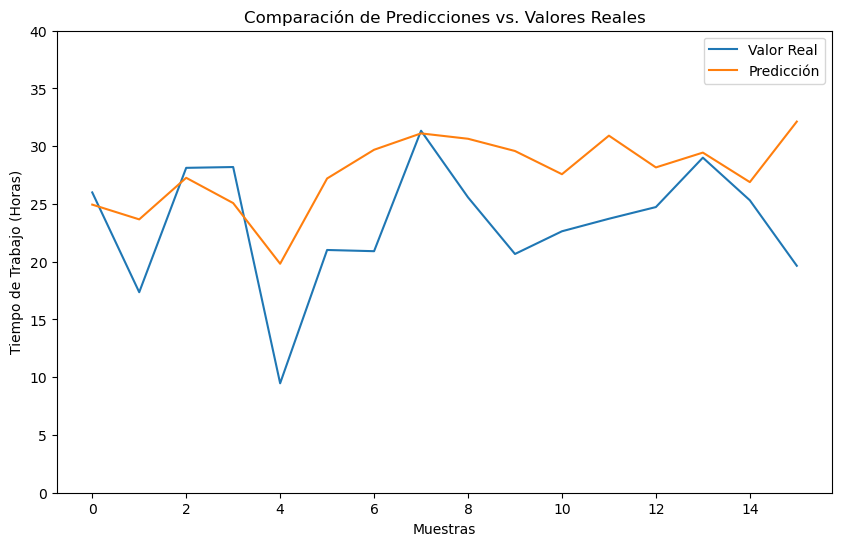

In [62]:
# Comparar predicciones con valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverted, label='Valor Real')
plt.plot(y_pred_inverted, label='Predicción')
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Muestras')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.ylim(0,40)
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test_inverted, y_pred_inverted))
mae = mean_absolute_error(y_test_inverted, y_pred_inverted)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 6.25351453766801
MAE: 5.059282751108346


In [64]:
error = pd.DataFrame(y_test_inverted-y_pred_inverted)

Desvación de 0: -4.400727965430207


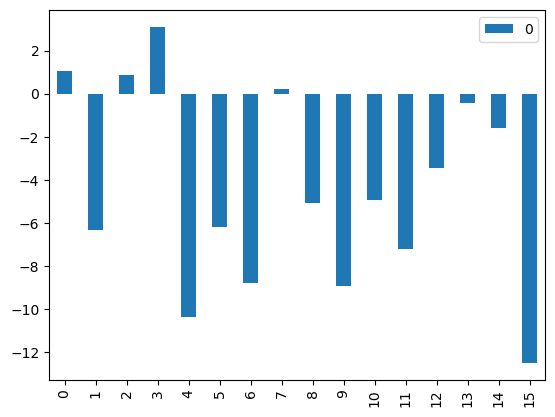

In [65]:
error.plot(kind = 'bar')
desviación_error = error.mean()
desviación_error = float(desviación_error.iloc[0])
print('Desvación de 0: ' + str(desviación_error))

In [66]:
#Entrenar modelo con todos los datos:

model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    learning_rate=0.1,  # Ajustado
    max_depth=10,         # Ajustado
    subsample=0.7,       # Ajustado
    colsample_bytree=0.9, # Ajustado
    n_estimators=500,    # Ajustado
    reg_alpha=0,       # Regularización L1
    reg_lambda=1,       # Regularización L2
    # # early_stopping_rounds= 50
    )

model.fit(
    df_X_xg, 
    df_y_xg, 
    verbose=True,
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
# Número de predicciones futuras que quieres hacer
n_pred = 16  # Por ejemplo, predecir las próximas 16 semanas

# Crear un DataFrame para almacenar las predicciones futuras
pred_futuras = pd.DataFrame(index=range(n_pred), columns=df_xg.columns)

# # Inicializar con la última secuencia de datos disponible
last_sequence = scaled_data[-sequence_length:]

# Modificar la lógica de predicción para incluir la nueva condición de 'holiday'
for i in range(n_pred):
    # Calcular la fecha de la predicción actual
    current_date = df_xg.index[-1] + pd.Timedelta(weeks=i+1)

    # Extraer el año, mes, semana y calcular si es un feriado
    current_year = current_date.year
    current_month = current_date.month
    current_week = current_date.isocalendar().week
    current_holiday = is_holiday_future(current_date) 

    # Concatenar la secuencia de datos con las características temporales actualizadas
    input_sequence = np.concatenate([last_sequence.flatten(), [current_year, current_month, current_week, current_holiday]])

    input_sequence = input_sequence.reshape(1, -1)
    
    next_prediction = model.predict(input_sequence)
    next_prediction_inverted = scaler.inverse_transform(next_prediction.reshape(-1, 1))[0][0]

    # Guardar los resultados en el DataFrame de predicciones futuras
    pred_futuras.loc[i, 'y'] = next_prediction_inverted
    pred_futuras.loc[i, 'ds'] = current_date
    pred_futuras.loc[i, 'year'] = current_year
    pred_futuras.loc[i, 'month'] = current_month
    pred_futuras.loc[i, 'week'] = current_week
    pred_futuras.loc[i, 'holiday'] = current_holiday

    # Actualizar la secuencia para la próxima predicción
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

# Imprimir las predicciones futuras
print(pred_futuras)
pred_futuras_compensadas_xg = pred_futuras.copy()
pred_futuras_compensadas_xg['y'] = pred_futuras_compensadas_xg['y'] + desviación_error

            y week  year month holiday         ds
0    24.05755   30  2024     7       0 2024-07-22
1   26.001934   31  2024     7       0 2024-07-29
2    9.770247   32  2024     8       1 2024-08-05
3    1.589119   33  2024     8       1 2024-08-12
4   20.399855   34  2024     8       0 2024-08-19
5   23.224033   35  2024     8       0 2024-08-26
6   30.100864   36  2024     9       0 2024-09-02
7   32.654453   37  2024     9       0 2024-09-09
8    35.86071   38  2024     9       0 2024-09-16
9   29.029865   39  2024     9       0 2024-09-23
10  27.418259   40  2024     9       0 2024-09-30
11  25.327278   41  2024    10       0 2024-10-07
12  35.108849   42  2024    10       0 2024-10-14
13  34.164867   43  2024    10       0 2024-10-21
14  29.109076   44  2024    10       0 2024-10-28
15  26.479162   45  2024    11       0 2024-11-04


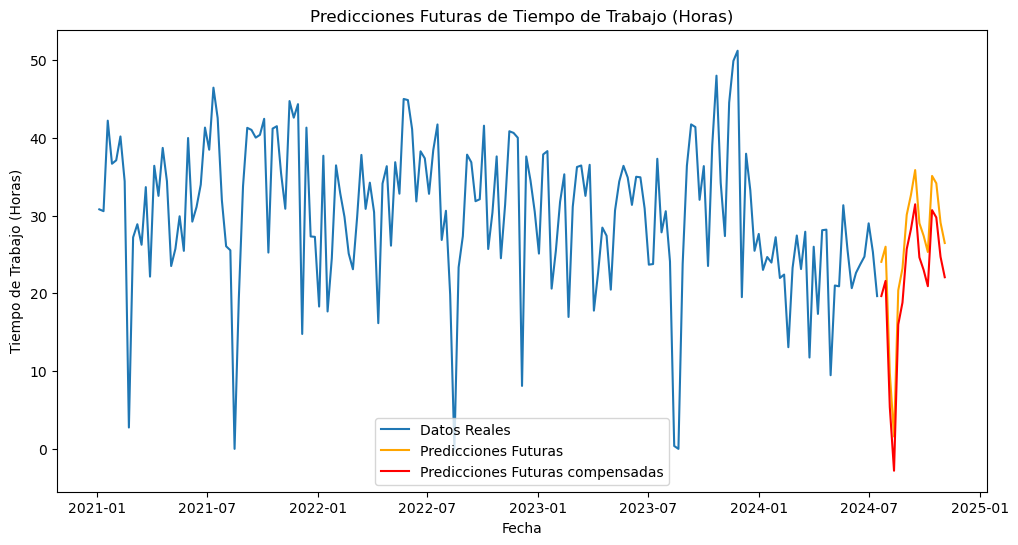

In [68]:
# Combinar predicciones futuras con los datos históricos para visualizar
df_combined = pd.concat([df_xg[['y']], pred_futuras.set_index('ds')[['y']]])

plt.figure(figsize=(12, 6))
plt.plot(df_xg.index, df_xg['y'], label='Datos Reales')
plt.plot(pred_futuras['ds'], pred_futuras['y'], label='Predicciones Futuras', color='orange')
plt.plot(pred_futuras['ds'], pred_futuras_compensadas_xg['y'], label='Predicciones Futuras compensadas', color='red')
plt.title('Predicciones Futuras de Tiempo de Trabajo (Horas)')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.legend()
plt.show()

In [69]:
#Reducido por las bravas, ¿¿¿Esta OK????

## 2.7: LSTM

In [70]:
df_lstm = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_lstm = df_lstm.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo'], axis=1)

In [71]:
ultima_fecha = df_lstm['ds'].max()
fechas_futuras = [ultima_fecha + pd.DateOffset(weeks=i+1) for i in range(16)]

In [72]:
df_lstm['week'] = df_lstm['ds'].dt.isocalendar().week
df_lstm['year'] = df_lstm['ds'].dt.isocalendar().year
df_lstm['month'] = df_lstm['ds'].dt.month

def is_holiday(y):
    
    # Si y no es None, aplicar el criterio original
    if y < 10:
        return 1
    else:
        return 0

def is_holiday_future(ds):
    week = ds.isocalendar().week
    month = ds.month
    
    # Verificar si la semana está en las semanas 32 o 33 de agosto
    if (week == 32 or week == 33) and month == 8:
        return 1
    else:
        return 0

df_lstm['holiday'] = df_lstm.apply(lambda row: is_holiday(row['y']), axis=1)

df_lstm_copia = df_lstm.copy()

In [73]:
df_lstm = pd.get_dummies(df_lstm, columns=['month', 'holiday'], drop_first=True)

In [74]:
df_lstm = df_lstm.drop('ds', axis = 1)
df_lstm = np.array(df_lstm).astype(np.float32)

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df_lstm)
scaled_data = pd.DataFrame(scaled_data)

In [76]:
#Mejor
sequence_length = 30 
#sequence_length = 52 Peor
#sequence_length = 20

X, y = [], []
for i in range(sequence_length, len(df_lstm)):

    data_append_X = scaled_data.iloc[i-sequence_length:i]
    
    X.append(data_append_X)
    
    y.append(scaled_data.iloc[i][0])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

In [77]:
#DF Futuro
df_futuro = pd.DataFrame({'ds': fechas_futuras, 'y': np.nan})
df_futuro['week'] = df_futuro['ds'].dt.isocalendar().week
df_futuro['year'] = df_futuro['ds'].dt.isocalendar().year
df_futuro['month'] = df_futuro['ds'].dt.month

df_futuro['holiday'] = df_futuro.apply(lambda row: is_holiday(row['y']), axis=1)
df_futuro['holiday'] = df_futuro.apply(lambda row: is_holiday_future(row['ds']), axis=1)

df_futuro = pd.get_dummies(df_futuro, columns=['month', 'holiday'], drop_first=False)

In [78]:
import pandas as pd

# Lista con el orden deseado de las columnas
orden_deseado = [
    'ds', 'y', 'week', 'year', 
    'month_2', 'month_3', 'month_4', 'month_5', 
    'month_6', 'month_7', 'month_8', 'month_9', 
    'month_10', 'month_11', 'month_12', 
    'holiday_1'
]

# Asegúrate de que todas las columnas necesarias estén presentes
for col in orden_deseado:
    if col not in df_futuro.columns:
        df_futuro[col] = False

# Reordenar el DataFrame según el orden deseado
df_futuro = df_futuro[orden_deseado]

In [79]:
df_futuro = df_futuro.drop('ds', axis = 1)
df_futuro = np.array(df_futuro).astype(np.float32)

scaled_data_future = scaler.transform(df_futuro)
scaled_data_future = pd.DataFrame(scaled_data_future)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, shuffle=False, random_state=101)

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Definir el modelo
model = Sequential()

# Primera capa LSTM con 250 unidades y Dropout de 0.2
model.add(LSTM(units=350, return_sequences=True, input_shape=(sequence_length, 15), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))  # Dropout reducido para capturar más detalles

# Segunda capa LSTM con 150 unidades y Dropout de 0.15
model.add(LSTM(units=150, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.15))  # Dropout reducido

# Tercera capa LSTM con 100 unidades y Dropout de 0.1
model.add(LSTM(units=100))
model.add(Dropout(0.1))

# Capa densa (fully connected) de salida
model.add(Dense(units=1))  # Sin activación para regresión

# Compilar el modelo con tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mse')
#Probado learning Rate 0.0001 peor. 0.0003 optimo.

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Ver la arquitectura del modelo
model.summary()


Epoch 1/70
4/4 [==============================] - 7s 560ms/step - loss: 0.7424 - val_loss: 0.5039
Epoch 2/70
4/4 [==============================] - 1s 186ms/step - loss: 0.5211 - val_loss: 0.5456
Epoch 3/70
4/4 [==============================] - 1s 192ms/step - loss: 0.4883 - val_loss: 0.4775
Epoch 4/70
4/4 [==============================] - 1s 193ms/step - loss: 0.4814 - val_loss: 0.4682
Epoch 5/70
4/4 [==============================] - 1s 196ms/step - loss: 0.4547 - val_loss: 0.4424
Epoch 6/70
4/4 [==============================] - 1s 184ms/step - loss: 0.4428 - val_loss: 0.4389
Epoch 7/70
4/4 [==============================] - 1s 184ms/step - loss: 0.4269 - val_loss: 0.4153
Epoch 8/70
4/4 [==============================] - 1s 191ms/step - loss: 0.4060 - val_loss: 0.4040
Epoch 9/70
4/4 [==============================] - 1s 188ms/step - loss: 0.3962 - val_loss: 0.3898
Epoch 10/70
4/4 [==============================] - 1s 194ms/step - loss: 0.3816 - val_loss: 0.3746
Epoch 11/70
4/4 [==

In [82]:
# Extraer los datos de pérdida de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

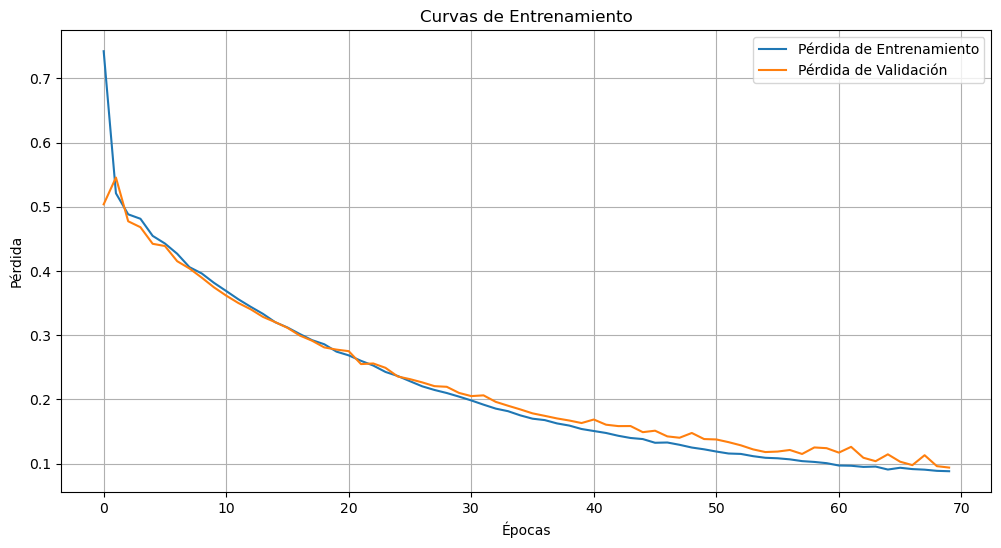

In [83]:
# Graficar las curvas de pérdida
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.title('Curvas de Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
# Hacer predicciones
predicted = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [85]:
predicted_scaled = np.zeros((predicted.shape[0], 15))
predicted_scaled[:, 0] = predicted.squeeze()
predicted_descaled = scaler.inverse_transform(predicted_scaled)[:, 0]

In [86]:
y_test_scaled = np.zeros((y_test.shape[0], 15))
y_test_scaled[:, 0] = y_test.squeeze()
y_test_descaled  = scaler.inverse_transform(y_test_scaled)[:, 0]

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_descaled, predicted_descaled))
mae = mean_absolute_error(y_test_descaled, predicted_descaled)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 9.184863363197746
MAE: 7.605589794763076


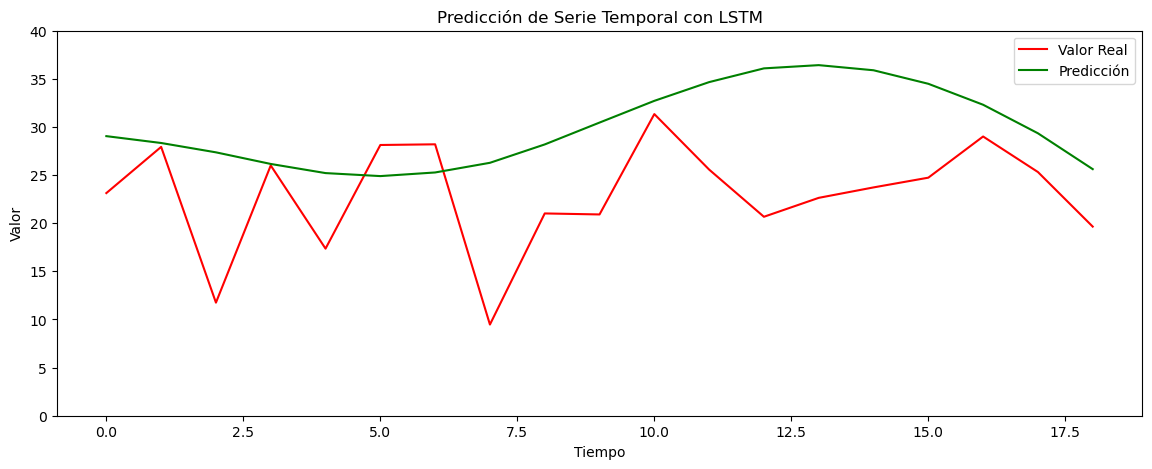

In [88]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_descaled, color='red', label='Valor Real')
plt.plot(predicted_descaled, color='green', label='Predicción')
plt.title('Predicción de Serie Temporal con LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.ylim(0,40)
plt.legend()
plt.show()

Desvación de 0: -6.957566669051536


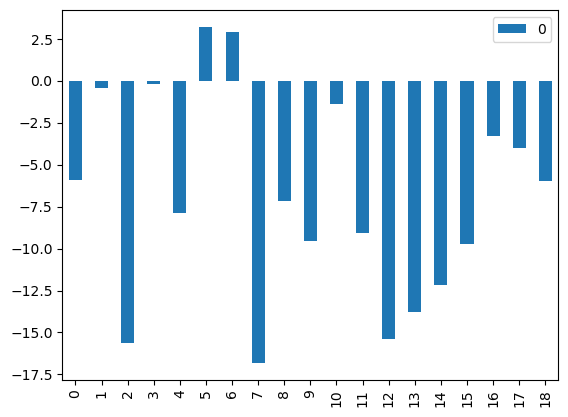

In [89]:
error = pd.DataFrame(y_test_descaled-predicted_descaled)
error.plot(kind = 'bar')
desviación_error = error.mean()
desviación_error = float(desviación_error.iloc[0])
print('Desvación de 0: ' + str(desviación_error))

In [90]:
#FALTA UNA SEMANA!!!!

scaled_data_future

data_future = scaled_data_future.values

In [91]:
import numpy as np

# Definir la cantidad de predicciones futuras que deseas (por ejemplo, 16 semanas)
n_predicciones = 16

# Obtener la última secuencia disponible de X_test o tu dataset de entrenamiento
ultima_secuencia = X_test[-1]  # Suponiendo que 'X_test' contiene secuencias de tamaño (30, n_features)

# Crear una lista para almacenar las predicciones futuras
predicciones_futuras = []

# Iterar para predecir futuras semanas
for i in range(n_predicciones):
    # Hacer la predicción para la última secuencia
    prediccion = model.predict(ultima_secuencia[np.newaxis, :, :])  # np.newaxis para agregar dimensión extra
    
    # Guardar la predicción
    predicciones_futuras.append(prediccion[0][0])
    
    # Crear la nueva secuencia
    nueva_fila = np.copy(ultima_secuencia[-1])  # Copia la última fila de la secuencia actual
    nueva_fila[0] = prediccion  # Reemplaza el valor de 'y' en la nueva fila

    
    # Si 'scaled_data_future' tiene características adicionales que no están en 'ultima_secuencia'
    if i < len(data_future):
        nueva_fila[1:] = data_future[i, 1:]  # Reemplaza las características one-hot encoding con los datos futuros
    else:
        nueva_fila[1:] = ultima_secuencia[-1, 1:]  # Mantener las características actuales si no hay más datos futuros

    # Eliminar la semana más antigua y agregar la nueva predicción
    nueva_secuencia = np.append(ultima_secuencia[1:], [nueva_fila], axis=0)  # Reemplazar la secuencia
    ultima_secuencia = nueva_secuencia  # Actualizar la secuencia

# Si los datos están escalados, puedes desescalar las predicciones:
# Suponiendo que 'predicciones_futuras' es un array unidimensional con las predicciones
predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)  # Asegúrate de que tenga la forma (n_samples, 1

predicciones_futuras_escaladas = np.zeros((predicciones_futuras.shape[0], 15))
predicciones_futuras_escaladas[:, 0] = predicciones_futuras.squeeze()
predicciones_futuras_desescaladas  = scaler.inverse_transform(predicciones_futuras_escaladas)[:, 0]

1/1 [==============================] - 0s 34ms/step


<Axes: >

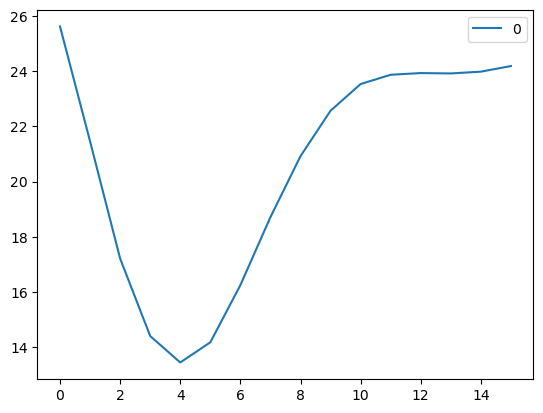

In [92]:
pd.DataFrame(predicciones_futuras_desescaladas).plot()

In [93]:
y_pred_lstm_datos = {
'ds': fechas_futuras,
'yhat': predicciones_futuras_desescaladas
}

y_pred_lstm = pd.DataFrame(y_pred_lstm_datos)

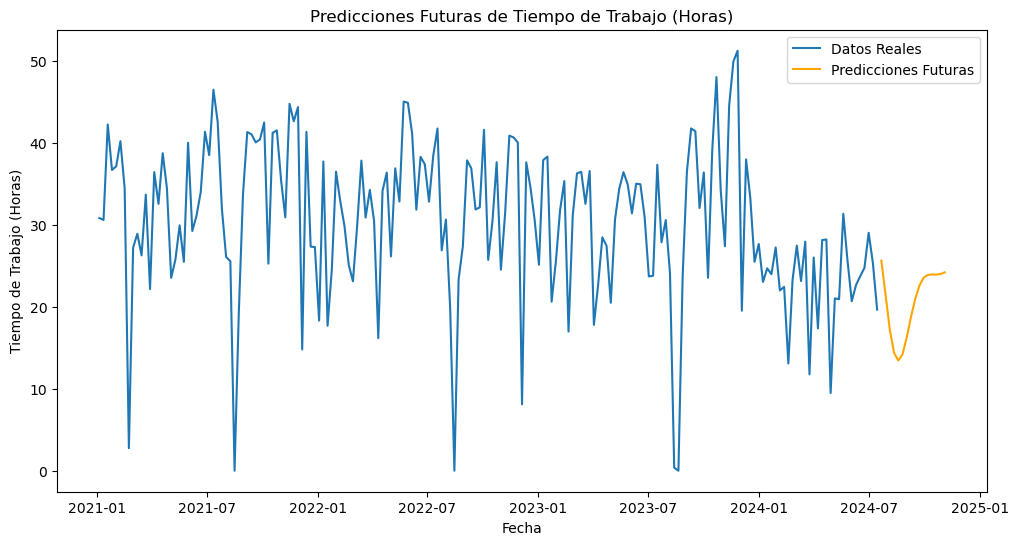

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(df_lstm_copia['ds'], df_lstm_copia['y'], label='Datos Reales')
plt.plot(y_pred_lstm['ds'], y_pred_lstm['yhat'], label='Predicciones Futuras', color='orange')
plt.title('Predicciones Futuras de Tiempo de Trabajo (Horas)')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.legend()
plt.show()


# 3: COMPARATIVA

<Axes: xlabel='ds', ylabel='y'>

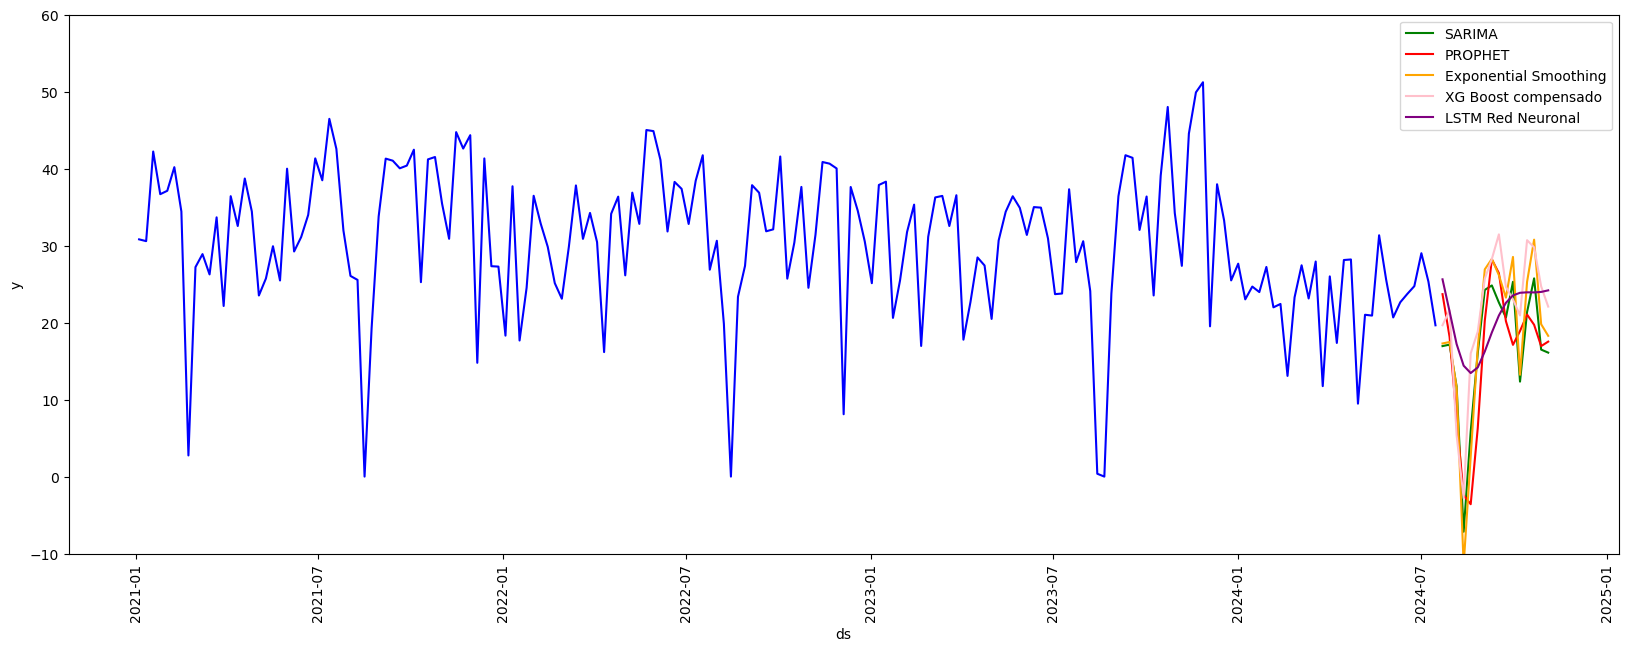

In [95]:

dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(-10,60)
plt.xticks(rotation=90)

sns.lineplot(data = df_sarima, x= df_sarima.index, y= 'y', color = 'blue')
sns.lineplot(data = y_pred_sarima, x= 'ds', y= 'yhat', color = 'green', label = 'SARIMA')
sns.lineplot(data = forecast_prophet, x= 'ds', y= 'yhat', color = 'red', label = 'PROPHET')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'orange', label = 'Exponential Smoothing')
sns.lineplot(data = pred_futuras_compensadas_xg, x= 'ds', y = 'y', color='pink', label='XG Boost compensado')
sns.lineplot(data = y_pred_lstm, x= 'ds', y = 'yhat', color='purple', label='LSTM Red Neuronal')

<Axes: xlabel='ds', ylabel='yhat'>

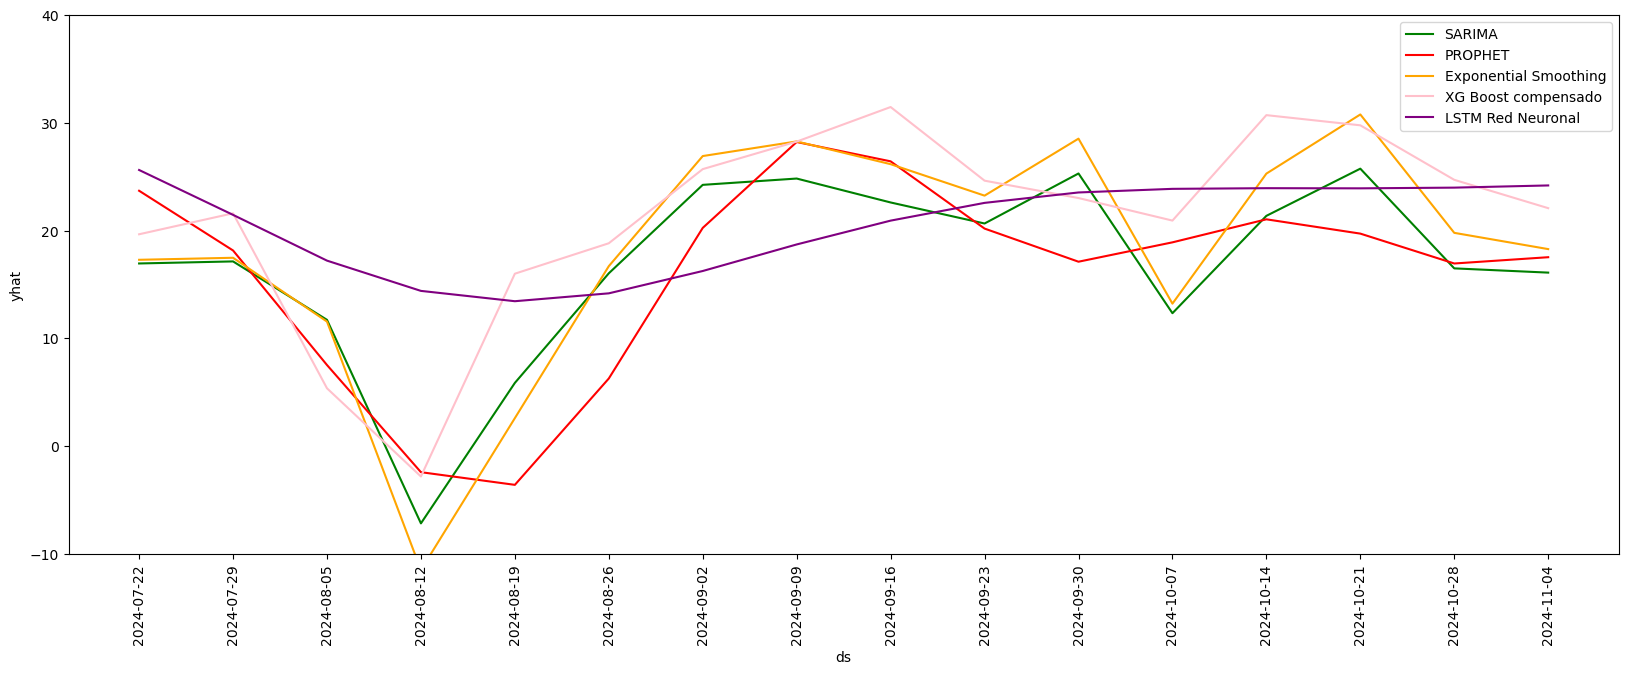

In [96]:
import matplotlib.dates as mdates

dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(-10,40)
plt.xticks(rotation=90)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))  # Etiquetas los lunes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato de la fecha

sns.lineplot(data = y_pred_sarima, x= 'ds', y= 'yhat', color = 'green', label = 'SARIMA')
sns.lineplot(data = forecast_prophet, x= 'ds', y= 'yhat', color = 'red', label = 'PROPHET')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'orange', label = 'Exponential Smoothing')
sns.lineplot(data = pred_futuras_compensadas_xg, x= 'ds', y = 'y', color='pink', label='XG Boost compensado')
sns.lineplot(data = y_pred_lstm, x= 'ds', y = 'yhat', color='purple', label='LSTM Red Neuronal')

# 4: Stacking

# 5: Representación